In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3 as sq
from datetime import datetime, timedelta, date
from netaddr import IPNetwork
import re
from pprint import pprint
from IPython.display import Markdown, display, HTML
import matplotlib.ticker as mtick
import scipy.stats as stats

In [2]:
display(HTML("<style>.container { width:80% !important; }</style>"))

def printmd(string):
    display(Markdown(string))

In [3]:
protocols = ['QUIC', 'TLS', 'HTTPS', 'TCP', 'UDP']

In [4]:
connection = sq.connect("../dataset/merged-web.db")
connection.row_factory = sq.Row

In [610]:
query = """
SELECT id, domain, protocol, server, vantagePoint, requestStart, responseStart, firstContentfulPaint, loadEventStart, loadEventEnd, encodedBodySize, decodedBodySize, transferSize, timestamp, redirectEnd
FROM measurements 
WHERE (error = "" or error is null) AND cacheWarming = 0 AND decodedBodySize > 0 AND vantagePoint != 'US East'
"""
df1 = pd.read_sql(query, connection, index_col="id")
df1.head()

,domain,protocol,server,vantagePoint,requestStart,responseStart,firstContentfulPaint,loadEventStart,loadEventEnd,encodedBodySize,decodedBodySize,transferSize,timestamp,redirectEnd
id,,,,,,,,,,,,,,
de94a059-5d68-a5ce-59ce-1a6ef56c734b,www.google.com,tls,34.101.136.158,Asia Pacific Northeast,449.4,572.8,667.1,1515.4,1520.9,43518,131394,43818,2022-04-18 00:01:07.454673,0.0
17d50fd0-b5a0-79b1-f3a0-7783bd2560c4,www.youtube.com,tls,34.101.136.158,Asia Pacific Northeast,430.2,525.2,1189.7,2451.7,2452.3,72348,798841,72648,2022-04-18 00:01:15.983375,0.0
5a070af4-ccb9-6b98-8858-aa13c35c5e79,www.facebook.com,tls,34.101.136.158,Asia Pacific Northeast,426.1,789.8,1439.4,1825.8,1830.0,23902,79882,24202,2022-04-18 00:01:23.922335,0.0
908e3a2b-a713-d249-2134-48820f931020,www.netflix.com,tls,34.101.136.158,Asia Pacific Northeast,802.8,1106.8,1554.2,2856.7,2856.7,40082,293175,40382,2022-04-18 00:01:31.049555,802.4
7d5d3b00-aa62-96da-299a-ef1525f87ab2,www.microsoft.com,tls,34.101.136.158,Asia Pacific Northeast,571.9,801.5,1519.8,1940.4,1948.6,47126,210946,47426,2022-04-18 00:01:38.612872,571.4


In [611]:
domain_order = df1.head(10)['domain'].tolist()

In [612]:
query = """
SELECT measurement_id, MAX(elapsed), MIN(elapsed), AVG(elapsed), COUNT(answer)
FROM lookups 
WHERE status = "NOERROR"
GROUP BY measurement_id
"""
df2 = pd.read_sql(query, connection, index_col="measurement_id")
df2.index.names = ['id']
df2.rename({'MAX(elapsed)': 'max_lookup_end', 'MIN(elapsed)': 'min_lookup_end', 'AVG(elapsed)': 'avg_lookup_end', 'COUNT(answer)': 'queries'}, axis=1, inplace=True)
df2.head()

,max_lookup_end,min_lookup_end,avg_lookup_end,queries
id,,,,
00002031-da3b-2369-6e3c-292d69af398a,467.196775,154.967710,187.101895,10
00002d25-2747-230e-3914-998bd6b96b55,560.219597,186.824821,311.719236,3
00003cc3-21c6-2931-f9be-7a726658a611,450.794165,152.656857,295.270936,8
000048ab-fefb-2b4d-1222-9d7567b583ea,310.404117,273.878427,286.136316,3
00006444-75d0-8e98-ee35-2ba26c3e54c0,501.352256,137.401209,250.574097,8


In [613]:
query = """
SELECT measurement_id, answer, elapsed
FROM lookups
WHERE 
(domain = "www.google.com."
OR domain = "www.youtube.com."
OR domain = "www.facebook.com."
OR domain = "www.netflix.com."
OR domain = "www.microsoft.com."
OR domain = "twitter.com."
OR domain = "www.instagram.com."
OR domain = "www.linkedin.com."
OR domain = "www.wikipedia.org."
OR domain = "www.baidu.com.")
GROUP BY measurement_id
"""
df3 = pd.read_sql(query, connection, index_col="measurement_id")
df3.index.names = ['id']
df3.head()

,answer,elapsed
id,,
00002031-da3b-2369-6e3c-292d69af398a,"www.google.com.,48,IN,A,142.250.204.4|",155.697689
00002d25-2747-230e-3914-998bd6b96b55,"www.facebook.com.,26,IN,CNAME,star-mini.c10r.f...",560.219597
00003cc3-21c6-2931-f9be-7a726658a611,"www.microsoft.com.,5,IN,CNAME,www.microsoft.co...",450.794165
000048ab-fefb-2b4d-1222-9d7567b583ea,"www.instagram.com.,1084,IN,CNAME,geo-p42.insta...",310.404117
00006444-75d0-8e98-ee35-2ba26c3e54c0,"twitter.com.,809,IN,A,104.244.42.65|twitter.co...",501.352256


In [614]:
df = pd.merge(df1, df2, 'left', on='id')
df = pd.merge(df, df3, 'left', on='id')
df['protocol'] = df['protocol'].str.upper()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head(10)

,domain,protocol,server,vantagePoint,requestStart,responseStart,firstContentfulPaint,loadEventStart,loadEventEnd,encodedBodySize,decodedBodySize,transferSize,timestamp,redirectEnd,max_lookup_end,min_lookup_end,avg_lookup_end,queries,answer,elapsed
id,,,,,,,,,,,,,,,,,,,,
de94a059-5d68-a5ce-59ce-1a6ef56c734b,www.google.com,TLS,34.101.136.158,Asia Pacific Northeast,449.4,572.8,667.1,1515.4,1520.9,43518,131394,43818,2022-04-18 00:01:07.454673,0.0,265.857882,88.543562,127.501060,5,"www.google.com.,245,IN,A,172.217.194.106|www.g...",265.857882
17d50fd0-b5a0-79b1-f3a0-7783bd2560c4,www.youtube.com,TLS,34.101.136.158,Asia Pacific Northeast,430.2,525.2,1189.7,2451.7,2452.3,72348,798841,72648,2022-04-18 00:01:15.983375,0.0,266.068803,87.172790,141.118718,10,"www.google.com.,234,IN,A,172.217.194.106|www.g...",88.947238
5a070af4-ccb9-6b98-8858-aa13c35c5e79,www.facebook.com,TLS,34.101.136.158,Asia Pacific Northeast,426.1,789.8,1439.4,1825.8,1830.0,23902,79882,24202,2022-04-18 00:01:23.922335,0.0,263.154500,87.636232,146.156522,3,"www.facebook.com.,297,IN,A,31.13.68.35|",263.154500
908e3a2b-a713-d249-2134-48820f931020,www.netflix.com,TLS,34.101.136.158,Asia Pacific Northeast,802.8,1106.8,1554.2,2856.7,2856.7,40082,293175,40382,2022-04-18 00:01:31.049555,802.4,266.573831,85.928809,162.243046,7,"www.netflix.com.,296,IN,A,52.38.7.83|www.netfl...",262.431446
7d5d3b00-aa62-96da-299a-ef1525f87ab2,www.microsoft.com,TLS,34.101.136.158,Asia Pacific Northeast,571.9,801.5,1519.8,1940.4,1948.6,47126,210946,47426,2022-04-18 00:01:38.612872,571.4,269.910491,83.194761,160.144367,10,"www.microsoft.com.,297,IN,A,23.195.153.175|",250.034221
5aa29070-1949-e582-3be3-25f86b484f99,www.instagram.com,TLS,34.101.136.158,Asia Pacific Northeast,694.3,1125.1,1148.7,2284.2,2285.3,28742,95433,29042,2022-04-18 00:01:45.687286,693.5,263.681110,87.757407,146.501902,3,"www.instagram.com.,297,IN,A,31.13.68.174|",263.681110
2f7c5ad0-02a5-3cbb-b35c-730234d23c60,twitter.com,TLS,34.101.136.158,Asia Pacific Northeast,307.5,441.2,562.0,873.7,873.7,20659,98716,20959,2022-04-18 00:01:51.669557,0.0,265.456855,88.345981,176.180690,4,"twitter.com.,795,IN,A,104.244.42.193|twitter.c...",265.456855
c8cad7cc-50e9-60e2-d146-a8d5a109e74c,www.baidu.com,TLS,34.101.136.158,Asia Pacific Northeast,425.2,539.2,898.1,2041.7,2046.6,87853,354074,88153,2022-04-18 00:01:57.582608,0.0,264.591755,87.712718,146.533715,6,"www.baidu.com.,297,IN,A,45.113.192.101|www.bai...",263.117028
7b47a9f9-5ffd-a6e0-f38a-1fbcd243a481,www.linkedin.com,TLS,34.101.136.158,Asia Pacific Northeast,298.2,628.1,1023.7,1147.4,1147.4,14948,127559,15248,2022-04-18 00:02:03.294836,0.0,282.891974,83.704866,209.882300,4,"www.linkedin.com.,298,IN,A,13.107.42.14|",250.811192


In [714]:
# order vantage Points
vp_order = ['US West', 'South America East', 'Europe Central', 'Asia Pacific Southeast', 'Asia Pacific Northeast', 'Africa South']

In [618]:
# Eliminate unwanted servers
servers_to_exclude = ['138.2.86.147', '43.132.147.94', '120.55.44.44', '199.101.171.125', '202.61.207.68', '168.138.163.222', '203.160.55.187', '37.114.32.80', '103.176.79.211', '47.107.121.125', '47.243.237.126', '93.115.24.205', '62.109.2.197']
df_tmp = df[~df.server.isin(servers_to_exclude)].copy()
df = df_tmp

In [623]:
len(df)

284133

In [625]:
# Add an approximation for the rtt to the dataframe
df_udp = df[df['protocol'] == 'UDP'].copy()
df_udp = df_udp[['server', 'vantagePoint', 'elapsed', 'timestamp']]
approx_rtts = []
last_server = ''

for index, row in df.iterrows():
    current_server = row.server
    if current_server != last_server:
        last_server = current_server
        df_udp = df_udp.groupby(['server', 'vantagePoint'], as_index=False, sort=False).mean()
    elapsed = df_udp[(df_udp['vantagePoint']==row.vantagePoint) & (df_udp['server']==current_server)]['elapsed']
    if not elapsed.empty:
        approx_rtt = float(elapsed)
    else:
        print('empty')
        approx_rtt = 9999.9
    approx_rtts.append(approx_rtt)
df['approx_rtt'] = approx_rtts

empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empty
empt

In [626]:
# Calculate the rts
rts = []
for index, row in df.iterrows():
    rt = row.elapsed / row.approx_rtt
    rts.append(rt)
df['rts'] = rts

In [627]:
# some metrics
df['timeByTransferSize'] = df['loadEventStart'] / df['transferSize']
df['timeByDecodedSize'] = df['loadEventStart'] / df['decodedBodySize']
df['difLookupFcp'] = df['firstContentfulPaint'] - df['max_lookup_end']
df['difFcpEnd'] = df['loadEventStart'] - df['firstContentfulPaint']
df['difLookupEnd'] = df['loadEventStart'] - df['elapsed']
df['serverRTT'] = df['responseStart'] - df['requestStart']

In [628]:
# order by average number of queries
df_new = df[['domain', 'queries']].copy()
df_new = df_new.groupby('domain').agg('mean')
df_new = df_new.sort_values('queries')
domain_order = df_new.index.tolist()

# Functions

In [16]:
def datespan(startDate, endDate, delta=timedelta(days=1)):
    currentDate = startDate
    while currentDate < endDate:
        yield currentDate
        currentDate += delta

In [17]:
def annotate_medians(ax, m1):
    mL1 = [str(int(s)) for s in m1]
    ind = 0
    offset = 0.16
    for tick in range(len(ax.get_yticklabels())):
        ax.text(m1[ind], tick-2*offset, mL1[ind],  verticalalignment='center',  color='black', weight='normal')
        ax.text(m1[ind+1], tick-offset, mL1[ind+1],  verticalalignment='center',  color='black', weight='normal')
        ax.text(m1[ind+2], tick, mL1[ind+2],  verticalalignment='center',  color='black', weight='normal')
        ax.text(m1[ind+3], tick+offset, mL1[ind+3],  verticalalignment='center',  color='black', weight='normal')
        ax.text(m1[ind+4], tick+2*offset, mL1[ind+4],  verticalalignment='center',  color='black', weight='normal')   
        ind += 5

In [18]:
def multiCompare(first='vantagePoint', first_val='All', second='domain', value_vars=['max_lookup_end', 'firstContentfulPaint', 'loadEventEnd'], medians=True, xlabel='ms', ylabel=None, server_domain=None, showfliers=False, xlim=None, save=None, showmeans=True):
    printmd(f"**{first_val}**")
    sns.set(font_scale=1.5)
    sns.set_style("whitegrid")
    
    if first_val == 'All' or first_val == '':
        df_filtered = df.copy()
    else:
        df_filtered = df[df[first] == first_val].copy()
    
    if second == 'vantagePoint':
        order = vp_order
    if second == 'domain':
        order = []
        for index, row in df_new.iterrows():
            domain_string = f"{index} ({int(row['queries'])})"
            df_filtered.loc[df_filtered.domain==index, 'domain'] = domain_string
            order.append(domain_string)
            
    if second == 'server':
        order = df_filtered['server'].unique().tolist()
        if server_domain:
            df_filtered = df_filtered[df_filtered['domain'] == server_domain]

    df_melted = pd.melt(df_filtered, id_vars=['protocol', second], value_vars=value_vars)
    axes = []
    for i, val_var in enumerate(value_vars):
        axes.append(sns.boxplot(x='value', y=second, meanprops=dict(markerfacecolor='white', markeredgecolor='red', marker='s'), medianprops=dict(color="lime", alpha=1, linewidth=2), hue='protocol', hue_order=protocols, data=df_melted[df_melted['variable'] == val_var], orient='h', showfliers=showfliers, showmeans=showmeans, order=order))
        if i == 0:
            ax0 = axes[0]
            handles, labels = ax0.get_legend_handles_labels()
        ax = axes[i]
        
        # set alpha
        #for patch in ax.artists:
        #   r, g, b, a = patch.get_facecolor()
        #   patch.set_facecolor((r, g, b, .9))
        
    if not ylabel:
        ylabel=second
    if xlim:
        ax0.set_xlim(xlim[0], xlim[1])
    ax0.set_ylabel(ylabel, fontsize=25)
    ax0.set_xlabel(xlabel, fontsize=22)
    ax0.tick_params(axis='y', labelsize=22)
    ax0.tick_params(axis='x', labelsize=18)
    ax0.grid(True)
    
    # medians
    if medians:
        for i, val_var in enumerate(value_vars):
            data=df_melted[df_melted['variable'] == val_var].copy()
            data[second] = pd.Categorical(data[second], order)
            data['protocol'] = pd.Categorical(data['protocol'], protocols)
            m1  = data.sort_values([second, 'protocol']).groupby([second, 'protocol'])['value'].median().values
            ax = axes[i]
            annotate_medians(ax, m1)
    
    plt.legend(handles, ['DoQ', 'DoT', 'DoH', 'DoTCP', 'DoUDP'], loc='best', fontsize='medium')
    if save:
        plt.savefig(f"figures/{save}.pdf", bbox_inches='tight')
    plt.show()

In [290]:
def calculateCDF(items, bins=500):
    count, bins_count = np.histogram(items, bins=bins)
    pdf = count / sum(count)
    # using numpy np.cumsum to calculate the CDF
    cdf = np.cumsum(pdf)
    # return bins_count, cdf
    return bins_count[1:], cdf

In [20]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

def print_cdf_values(times_dict, percentage):
    data = {'UDP': [], 'QUIC': [], 'TLS': [], 'HTTPS': [], 'TCP': []}
    keys = []
    for key, value in times_dict.items():
        keys.append(key)
        st = value
        
        x,y = calculateCDF(st['UDP'])
        idx, val = find_nearest(y, percentage)
        data['UDP'].append(int(x[idx]))

        x,y = calculateCDF(st['QUIC'])
        idx, val = find_nearest(y, percentage)
        data['QUIC'].append(int(x[idx]))

        x,y = calculateCDF(st['TLS'])
        idx, val = find_nearest(y, percentage)
        data['TLS'].append(int(x[idx]))

        x,y = calculateCDF(st['HTTPS'])
        idx, val = find_nearest(y, percentage)
        data['HTTPS'].append(int(x[idx]))

        x,y = calculateCDF(st['TCP'])
        idx, val = find_nearest(y, percentage)
        data['TCP'].append(int(x[idx]))
        
    return pd.DataFrame(data, keys)

In [22]:
times_dict = {}
for domain in domain_order:
    dom_df = df[df['domain'] == domain]
    times_dict[domain] = {}
    dom_df = dom_df[dom_df['firstContentfulPaint'] > 0]
    print(f"\n{domain}\n")
    for protocol in protocols:
        times_dict[domain][protocol] = dom_df[dom_df['protocol'] == protocol]['firstContentfulPaint']
        print(f"{protocol} - {times_dict[domain][protocol].mean()}")
print_cdf_values(times_dict, 0.75)


www.wikipedia.org

QUIC - 1240.517168758587
TLS - 1430.7852426915006
HTTPS - 1428.2698578600052
TCP - 1238.0032872459924
UDP - 1062.0139314064465

www.instagram.com

QUIC - 1720.1202171826299
TLS - 1912.0605304961719
HTTPS - 1919.6976555017764
TCP - 1720.8335764058077
UDP - 1536.98627006053

www.facebook.com

QUIC - 2309.1183386486177
TLS - 2494.002324238482
HTTPS - 2492.268833625977
TCP - 2474.164869616973
UDP - 2128.3230203119647

www.linkedin.com

QUIC - 1528.0116256834217
TLS - 1715.6487489691108
HTTPS - 1720.391342997926
TCP - 1708.2488244938975
UDP - 1372.3316410531572

www.google.com

QUIC - 1082.4168703478194
TLS - 1255.1947095149058
HTTPS - 1258.3838359644844
TCP - 1078.1041868415034
UDP - 911.2726090063105

www.baidu.com

QUIC - 1705.1983710012112
TLS - 1820.9613647056187
HTTPS - 1862.1714264446512
TCP - 1656.357841484115
UDP - 1537.94702846123

twitter.com

QUIC - 701.2495033889469
TLS - 850.3527342505851
HTTPS - 853.1006214152369
TCP - 684.6990583180673
UDP - 545.518602047

,UDP,QUIC,TLS,HTTPS,TCP
www.wikipedia.org,1342,1586,1838,1840,1586
www.instagram.com,1889,2129,2369,2361,2113
www.facebook.com,2817,3059,3320,3318,3299
www.linkedin.com,1783,2006,2252,2259,2257
www.google.com,1213,1455,1694,1690,1448
www.baidu.com,1928,2156,2348,2386,2100
twitter.com,680,956,1203,1202,927
www.netflix.com,2132,2373,2792,2627,2627
www.microsoft.com,3735,3939,4094,4188,4527
www.youtube.com,2592,2768,2929,2947,2953


In [629]:
# normalize data
normalized_df = pd.DataFrame()
for vp in vp_order:
    df_vp = df[df['vantagePoint'] == vp].copy()
    for server in df_vp['server'].unique():
        df_server = df_vp[df_vp['server'] == server].copy()
        for domain in domain_order:
            df_domain = df_server[df_server['domain'] == domain].copy()
            df_domain['loadEventStart']=(df_domain['loadEventStart']-df_domain['loadEventStart'].mean())/df_domain['loadEventStart'].std()
            normalized_df = pd.concat([normalized_df, df_domain])

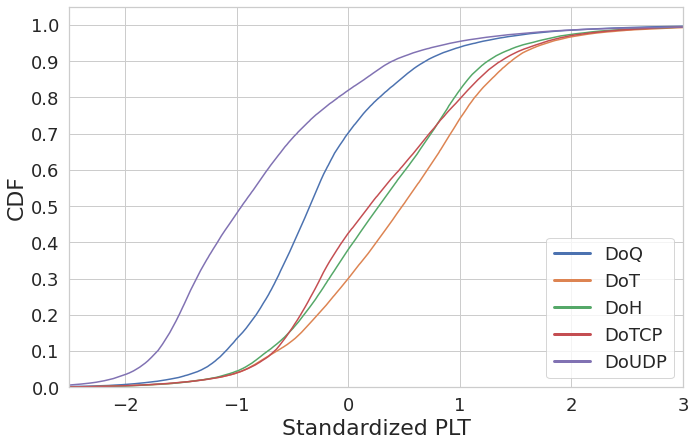

In [630]:
fig, ax = plt.subplots(figsize=(11, 7))
times = {}

for protocol in protocols:
    x = normalized_df[normalized_df['protocol'] == protocol]['loadEventStart']
    x = x[~np.isnan(x)]
    times[protocol] = x

sns.lineplot(x=calculateCDF(times['QUIC'], bins=1000)[0], y=calculateCDF(times['QUIC'], bins=1000)[1], label="DoQ", ax=ax)
sns.lineplot(x=calculateCDF(times['TLS'], bins=1000)[0], y=calculateCDF(times['TLS'], bins=1000)[1], label="DoT", ax=ax)
sns.lineplot(x=calculateCDF(times['HTTPS'], bins=1000)[0], y=calculateCDF(times['HTTPS'], bins=1000)[1], label="DoH", ax=ax)
sns.lineplot(x=calculateCDF(times['TCP'], bins=1000)[0], y=calculateCDF(times['TCP'], bins=1000)[1], label="DoTCP", ax=ax)
sns.lineplot(x=calculateCDF(times['UDP'], bins=1000)[0], y=calculateCDF(times['UDP'], bins=1000)[1], label="DoUDP", ax=ax)

ax.set_xlabel("Standardized PLT", fontsize = 22)
ax.set_ylabel("CDF", fontsize = 22)
ax.tick_params(labelleft=True)
ax.tick_params(labelbottom=True)
ax.tick_params(axis='both', labelsize=18)
ax.set_ylim(0.0, 1.05)
ax.yaxis.set_ticks(np.arange(0.0, 1.01, 0.1))
ax.set_xlim(-2.5, 3)

leg = ax.legend(loc="lower right", fontsize='medium')
for line in leg.get_lines():
    line.set_linewidth(3.0)

plt.savefig("figures/standardized-cdf-plt.pdf", bbox_inches='tight')
plt.show()

In [631]:
# normalize data for fcp
normalized_df_fcp = pd.DataFrame()
for vp in vp_order:
    df_vp = df[(df['vantagePoint'] == vp) & (df['firstContentfulPaint'] > 0.0)].copy()
    for server in df_vp['server'].unique():
        df_server = df_vp[df_vp['server'] == server].copy()
        for domain in domain_order:
            df_domain = df_server[df_server['domain'] == domain].copy()
            df_domain['firstContentfulPaint']=(df_domain['firstContentfulPaint']-df_domain['firstContentfulPaint'].mean())/df_domain['firstContentfulPaint'].std()
            normalized_df_fcp = pd.concat([normalized_df_fcp, df_domain])

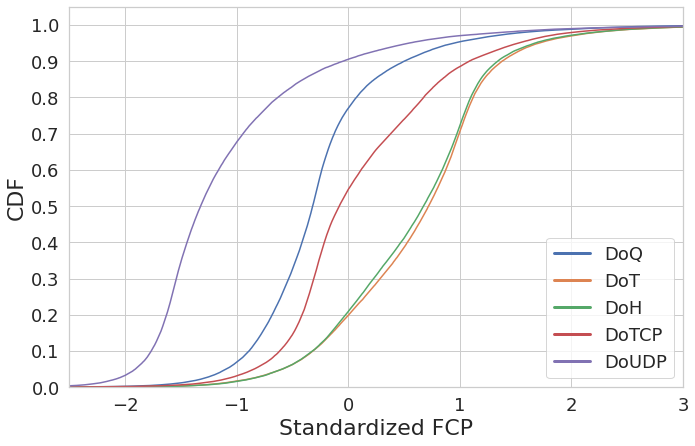

In [633]:
fig, ax = plt.subplots(figsize=(11, 7))
times = {}

for protocol in protocols:
    x = normalized_df_fcp[normalized_df_fcp['protocol'] == protocol]['firstContentfulPaint']
    x = x[~np.isnan(x)]
    times[protocol] = x

sns.lineplot(x=calculateCDF(times['QUIC'], bins=1000)[0], y=calculateCDF(times['QUIC'], bins=1000)[1], label="DoQ", ax=ax)
sns.lineplot(x=calculateCDF(times['TLS'], bins=1000)[0], y=calculateCDF(times['TLS'], bins=1000)[1], label="DoT", ax=ax)
sns.lineplot(x=calculateCDF(times['HTTPS'], bins=1000)[0], y=calculateCDF(times['HTTPS'], bins=1000)[1], label="DoH", ax=ax)
sns.lineplot(x=calculateCDF(times['TCP'], bins=1000)[0], y=calculateCDF(times['TCP'], bins=1000)[1], label="DoTCP", ax=ax)
sns.lineplot(x=calculateCDF(times['UDP'], bins=1000)[0], y=calculateCDF(times['UDP'], bins=1000)[1], label="DoUDP", ax=ax)

ax.set_xlabel("Standardized FCP", fontsize = 22)
ax.set_ylabel("CDF", fontsize = 22)
ax.tick_params(labelleft=True)
ax.tick_params(labelbottom=True)
ax.tick_params(axis='both', labelsize=18)
ax.set_ylim(0.0, 1.05)
ax.yaxis.set_ticks(np.arange(0.0, 1.01, 0.1))
ax.set_xlim(-2.5, 3)

leg = ax.legend(loc="lower right", fontsize='medium')
for line in leg.get_lines():
    line.set_linewidth(3.0)

plt.savefig("figures/standardized-cdf-fcp.pdf", bbox_inches='tight')
plt.show()

In [43]:
x_vp = 'Africa South'
x_ser = '31.31.202.109'
x_dom = 'www.youtube.com'
times_normal = df[(df['vantagePoint'] == x_vp) & (df['domain'] == x_dom) & (df['server'] == x_ser)].copy()
times_std = normalized_df[(normalized_df['vantagePoint'] == x_vp) & (normalized_df['server'] == x_ser) & (normalized_df['domain'] == x_dom)].copy()

median_normal_udp = times_normal[times_normal['protocol'] == 'TLS']['loadEventStart'].median()
median_normal_quic = times_normal[times_normal['protocol'] == 'UDP']['loadEventStart'].median()

median_std_udp = times_std[times_std['protocol'] == 'TLS']['loadEventStart'].median()
median_std_quic = times_std[times_std['protocol'] == 'UDP']['loadEventStart'].median()

20


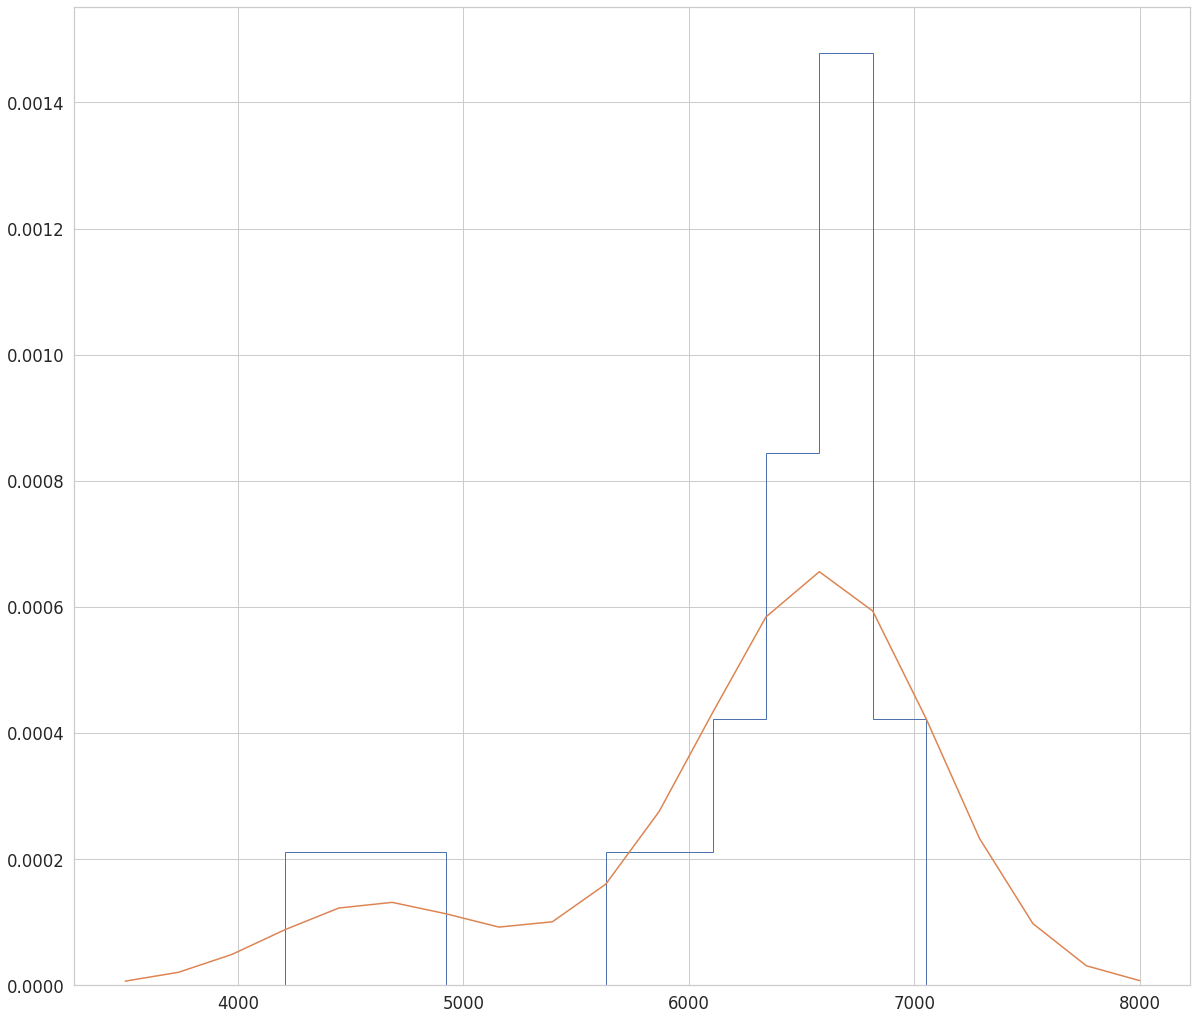

In [44]:
noise = times_normal['loadEventStart'].tolist()
density = stats.gaussian_kde(noise)
n, x, _ = plt.hist(noise, bins=np.linspace(3500, 8000, 20), 
                   histtype=u'step', density=True)  
plt.plot(x, density(x))
plt.show()

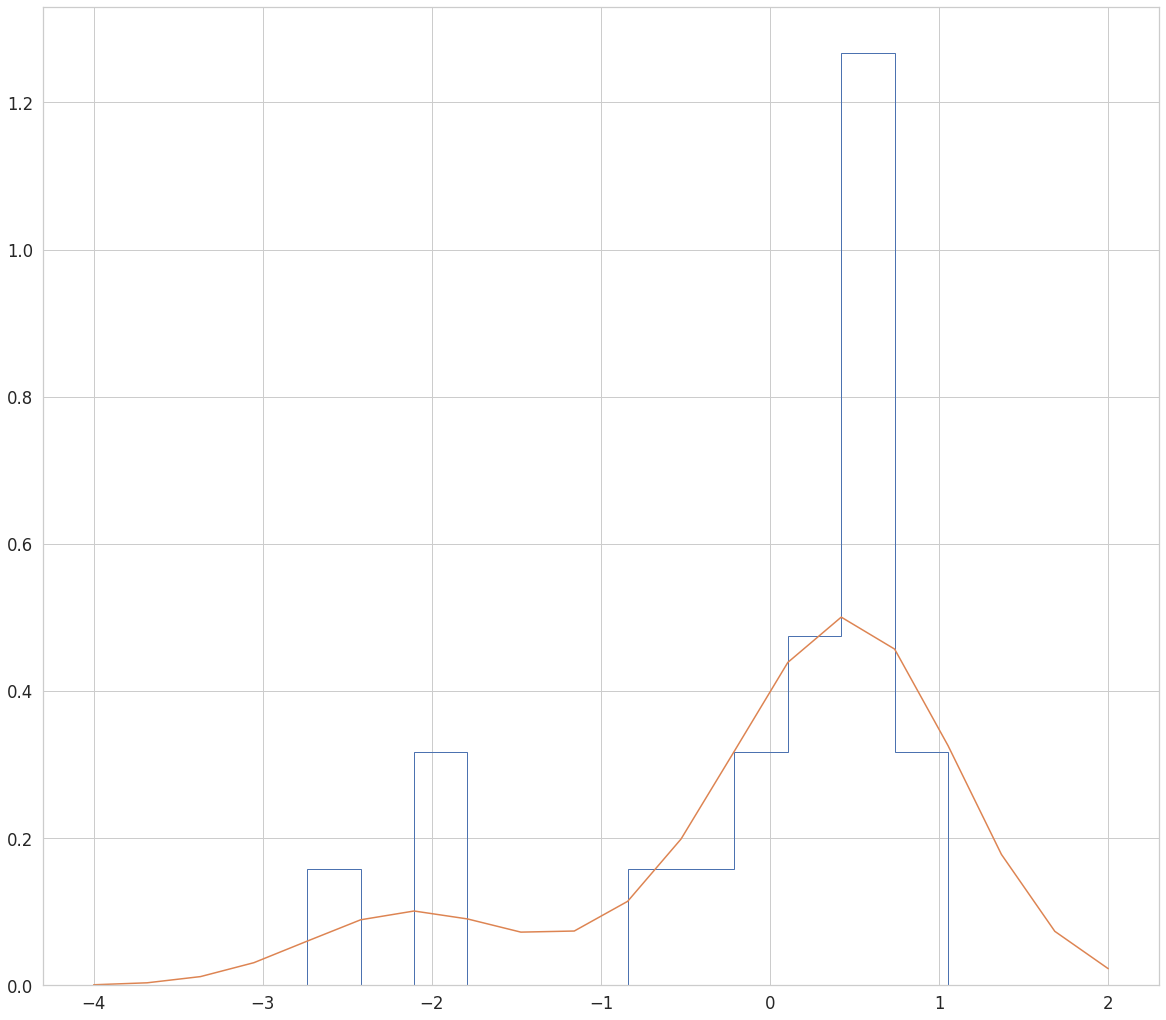

In [47]:
noise = times_std['loadEventStart'].tolist()
density = stats.gaussian_kde(noise)
n, x, _ = plt.hist(noise, bins=np.linspace(-4, 2, 20), 
                   histtype=u'step', density=True)  
plt.plot(x, density(x))
plt.show()

# Plots

**147.182.195.29**

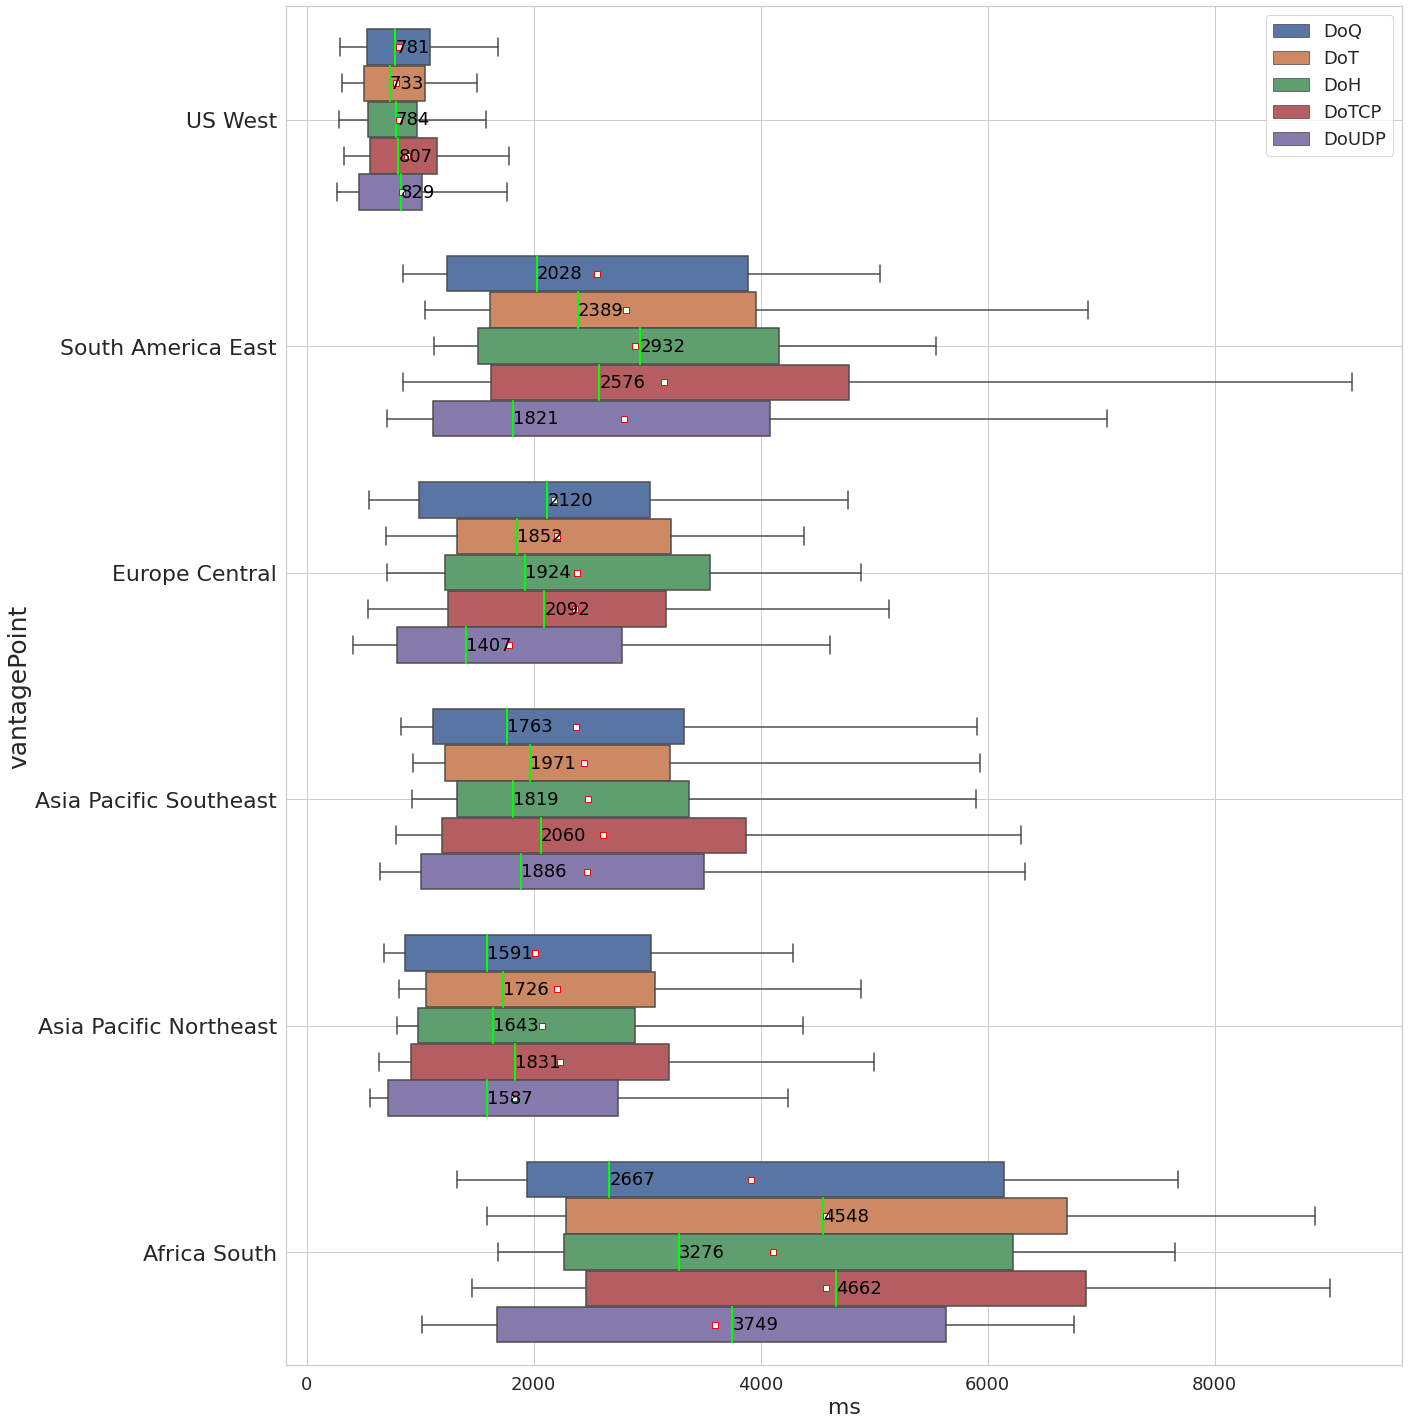

In [875]:
multiCompare('server', '147.182.195.29', 'vantagePoint', ['loadEventStart'])

***Domain Comparison ordered by Number of Queries (Load Event Start)***

**US West**

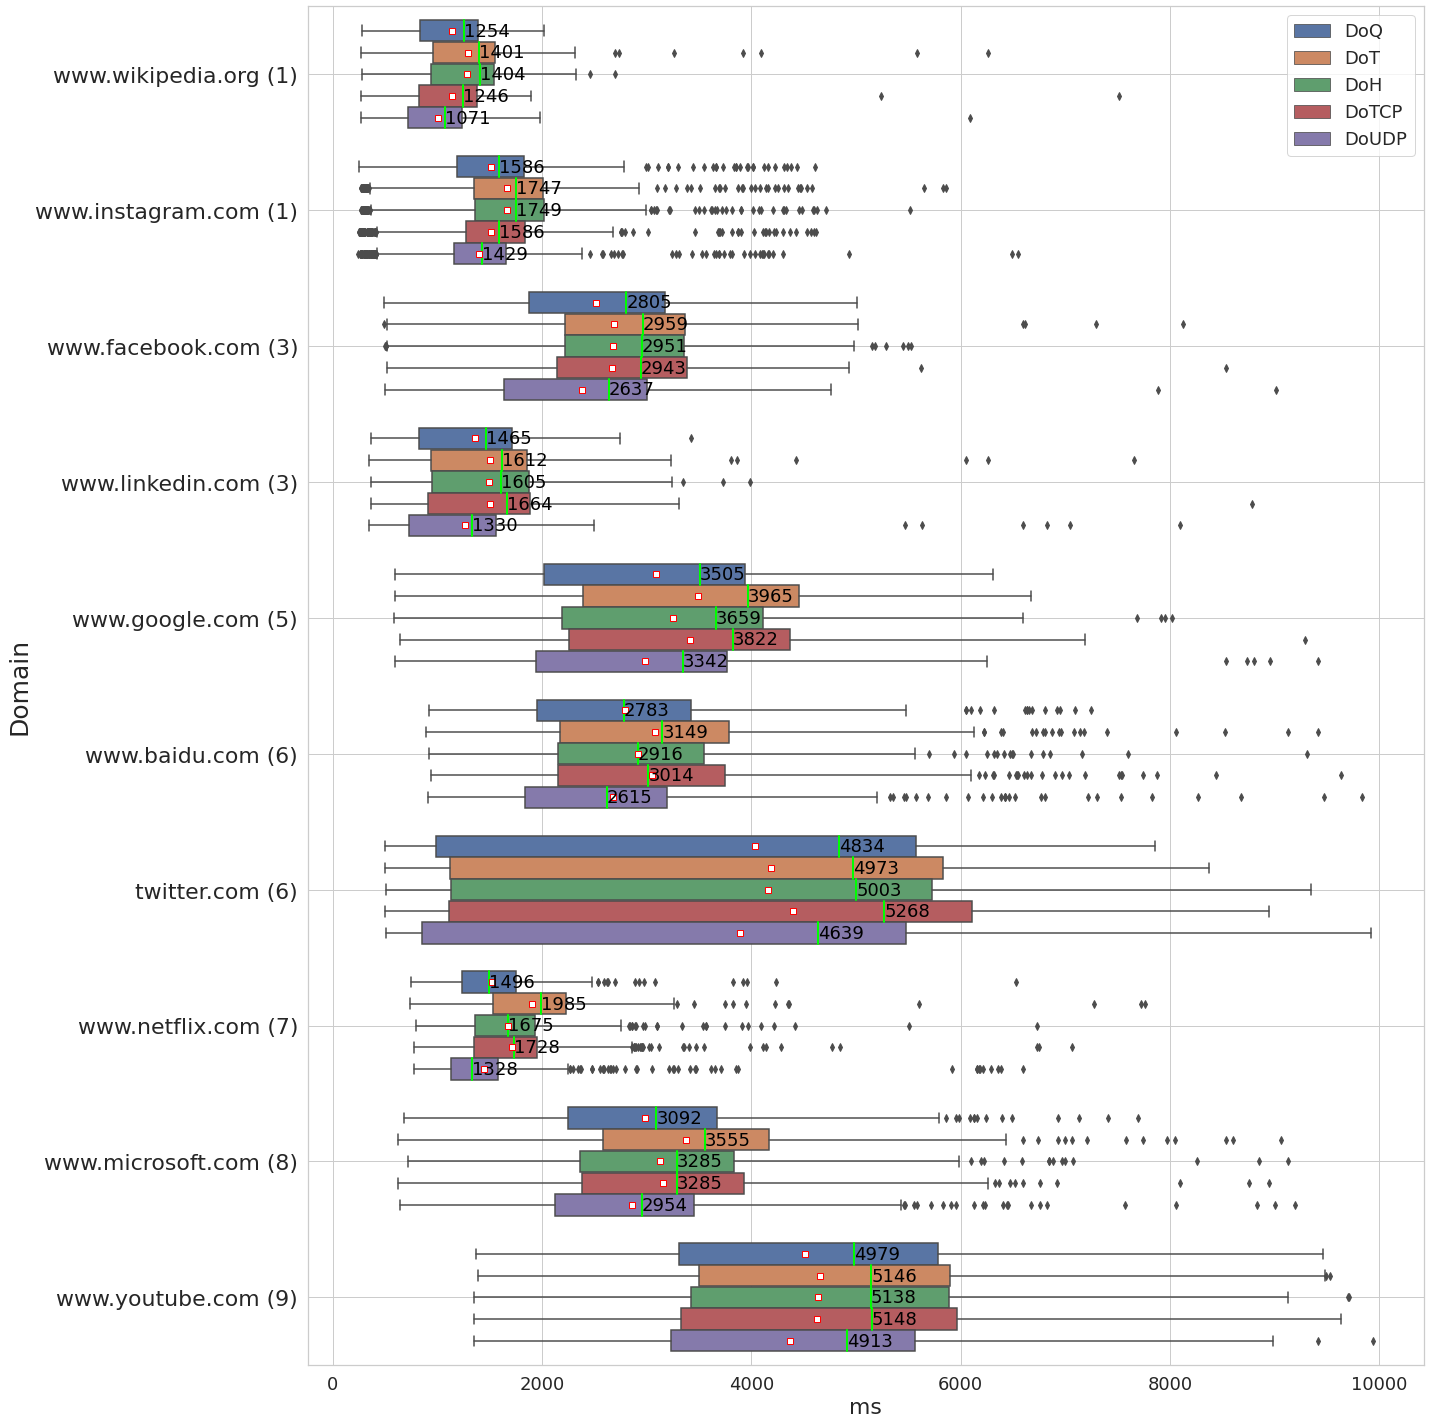

**South America East**

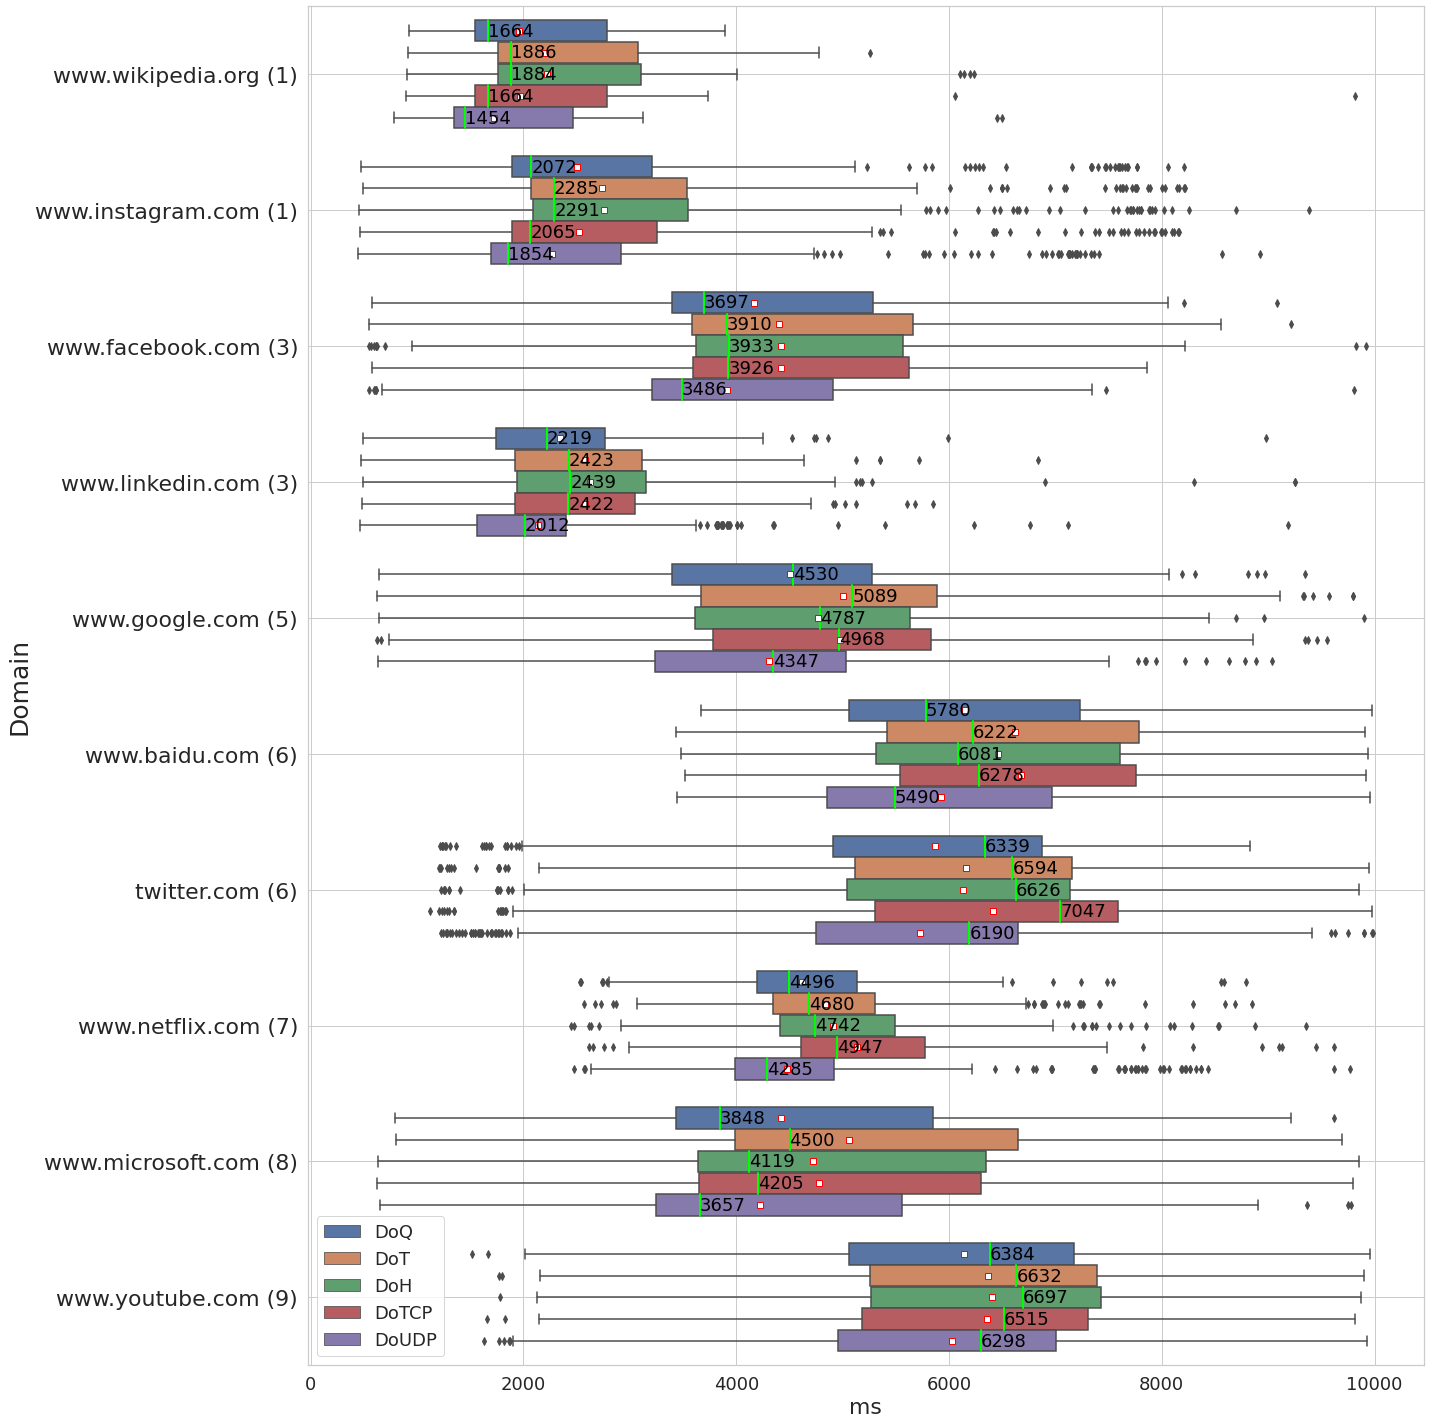

**Europe Central**

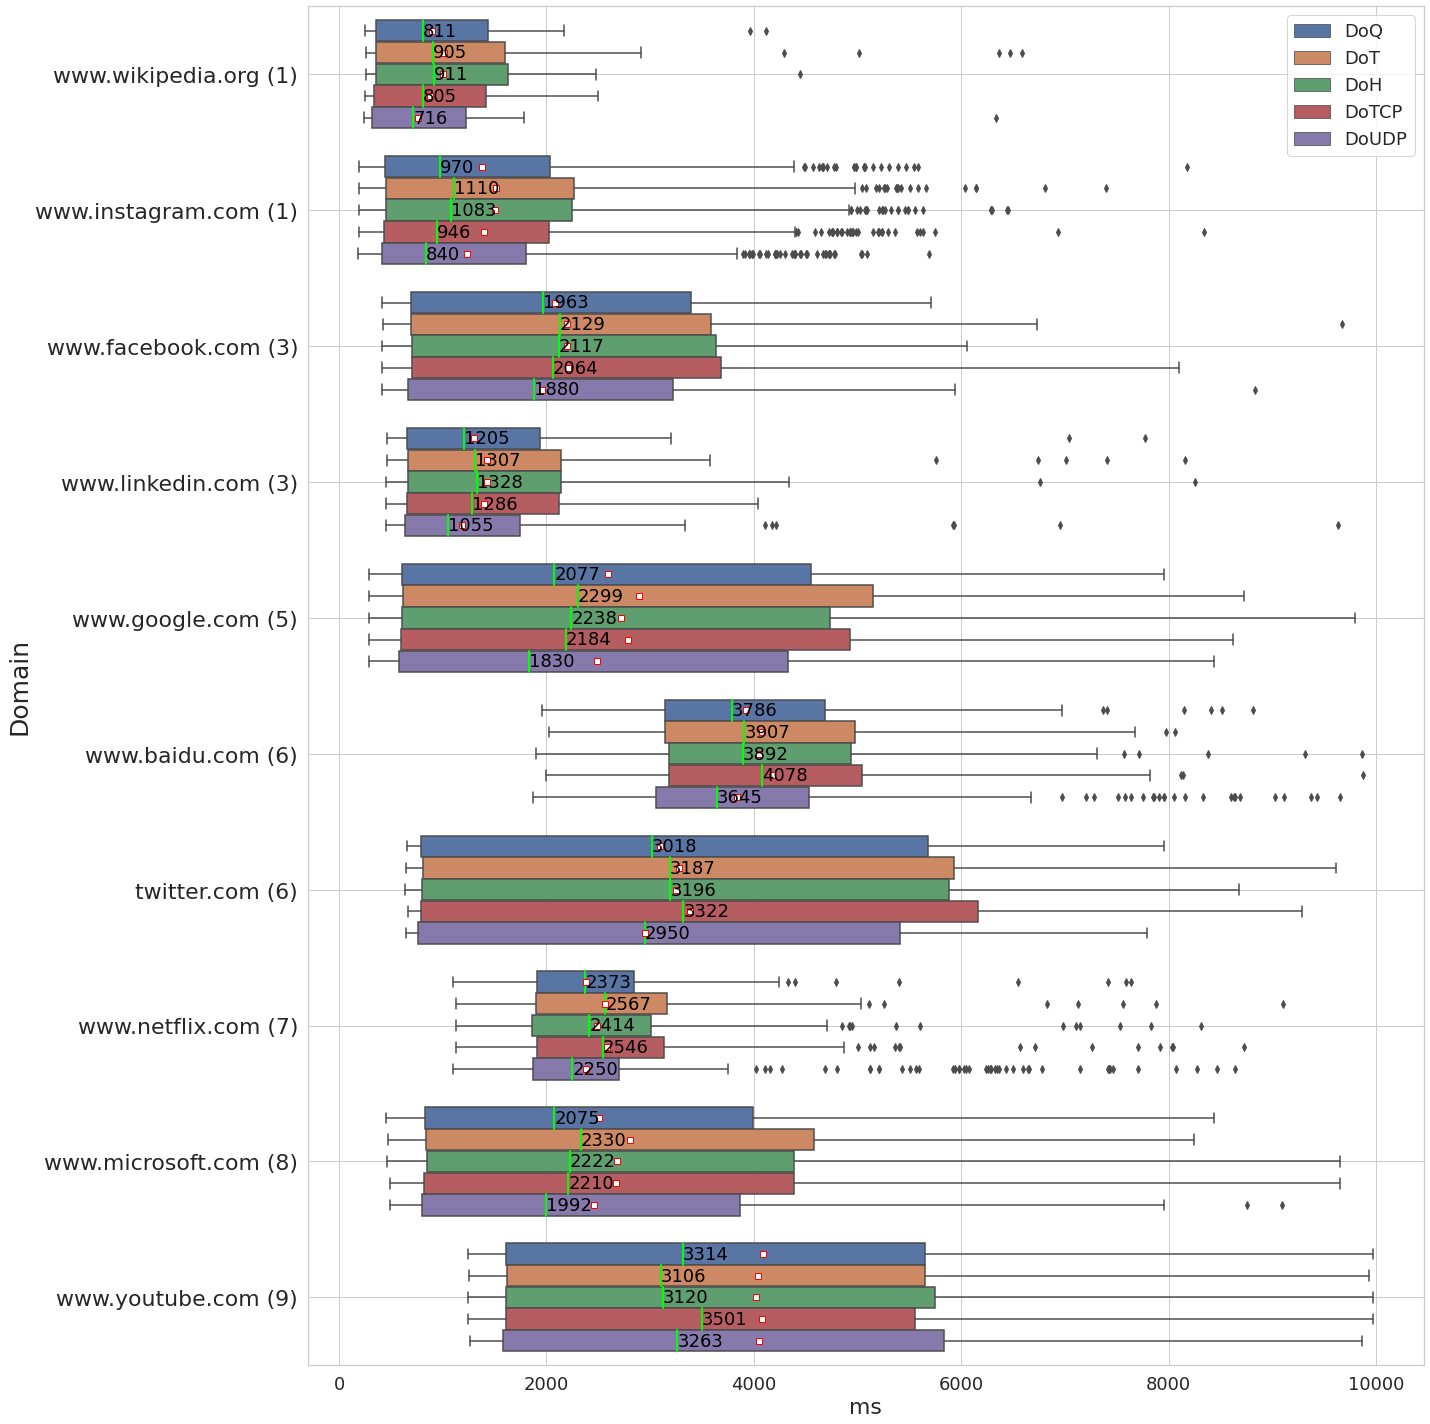

**Asia Pacific Southeast**

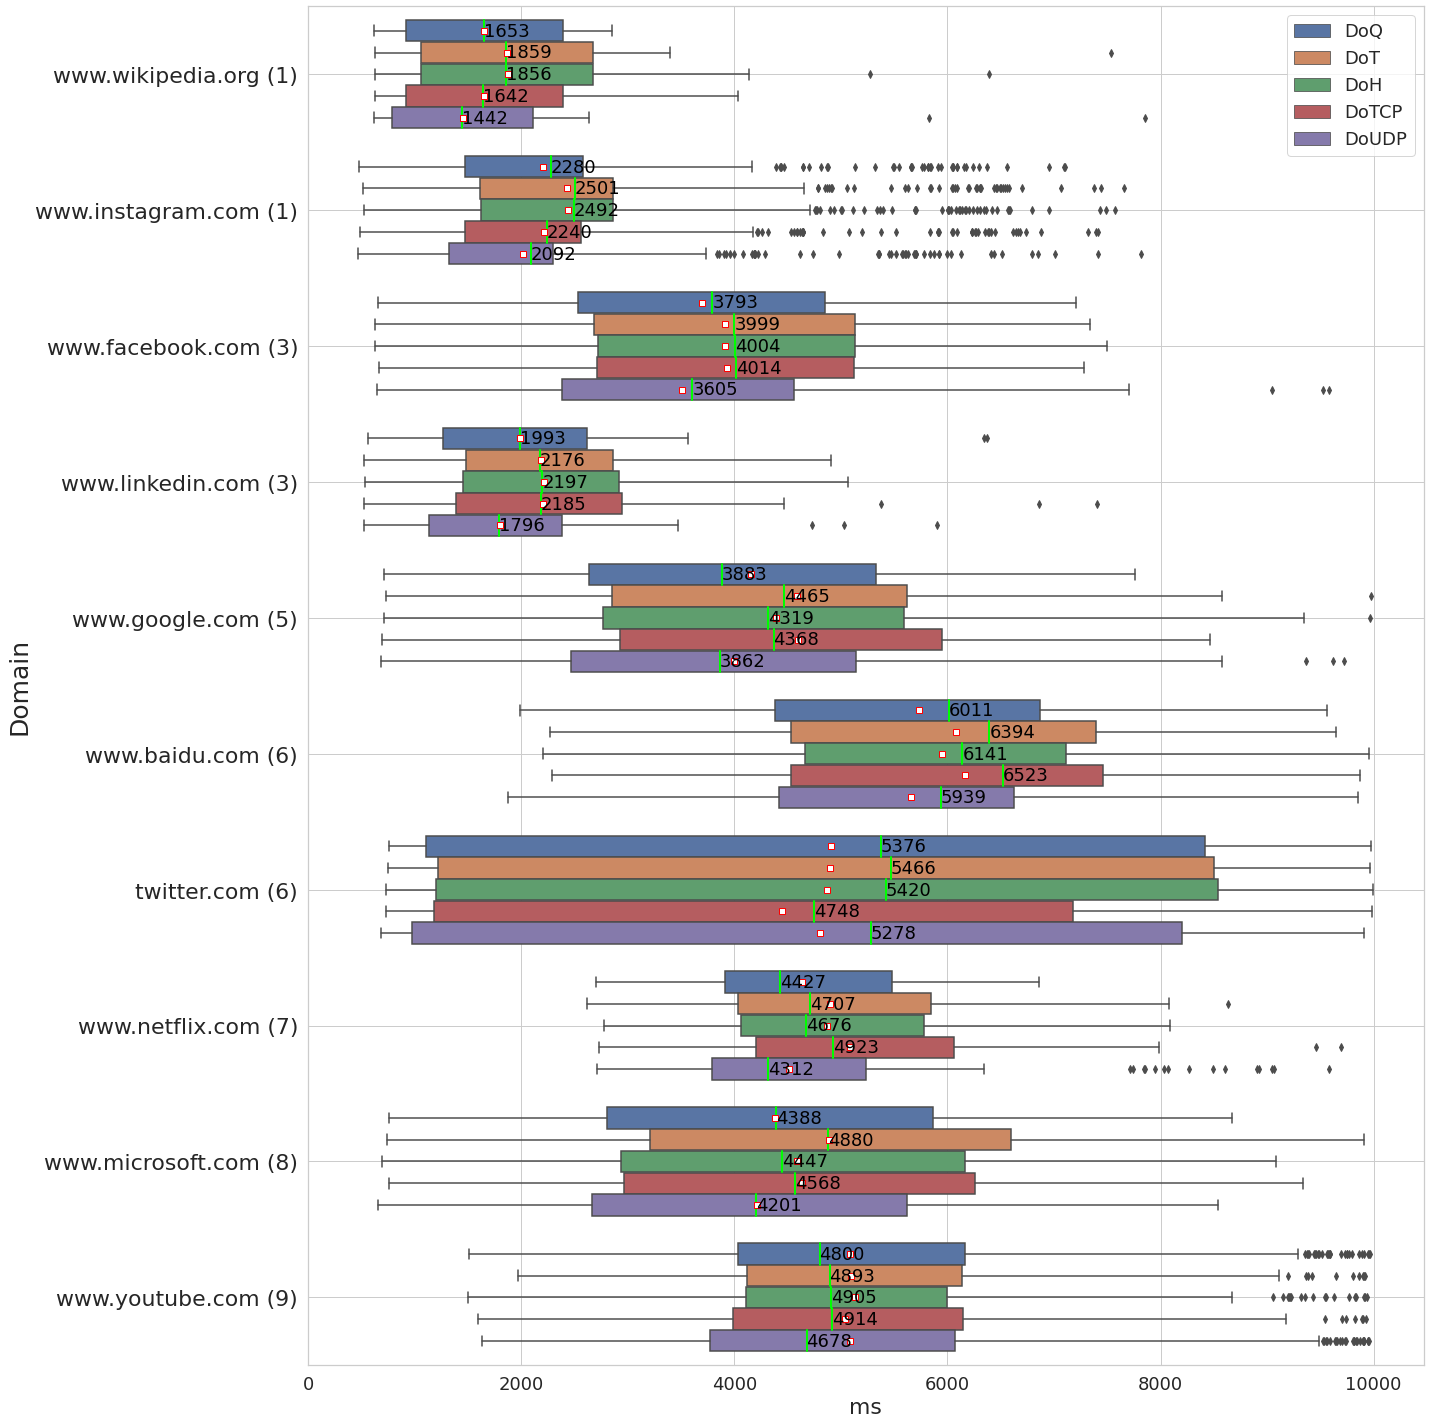

**Asia Pacific Northeast**

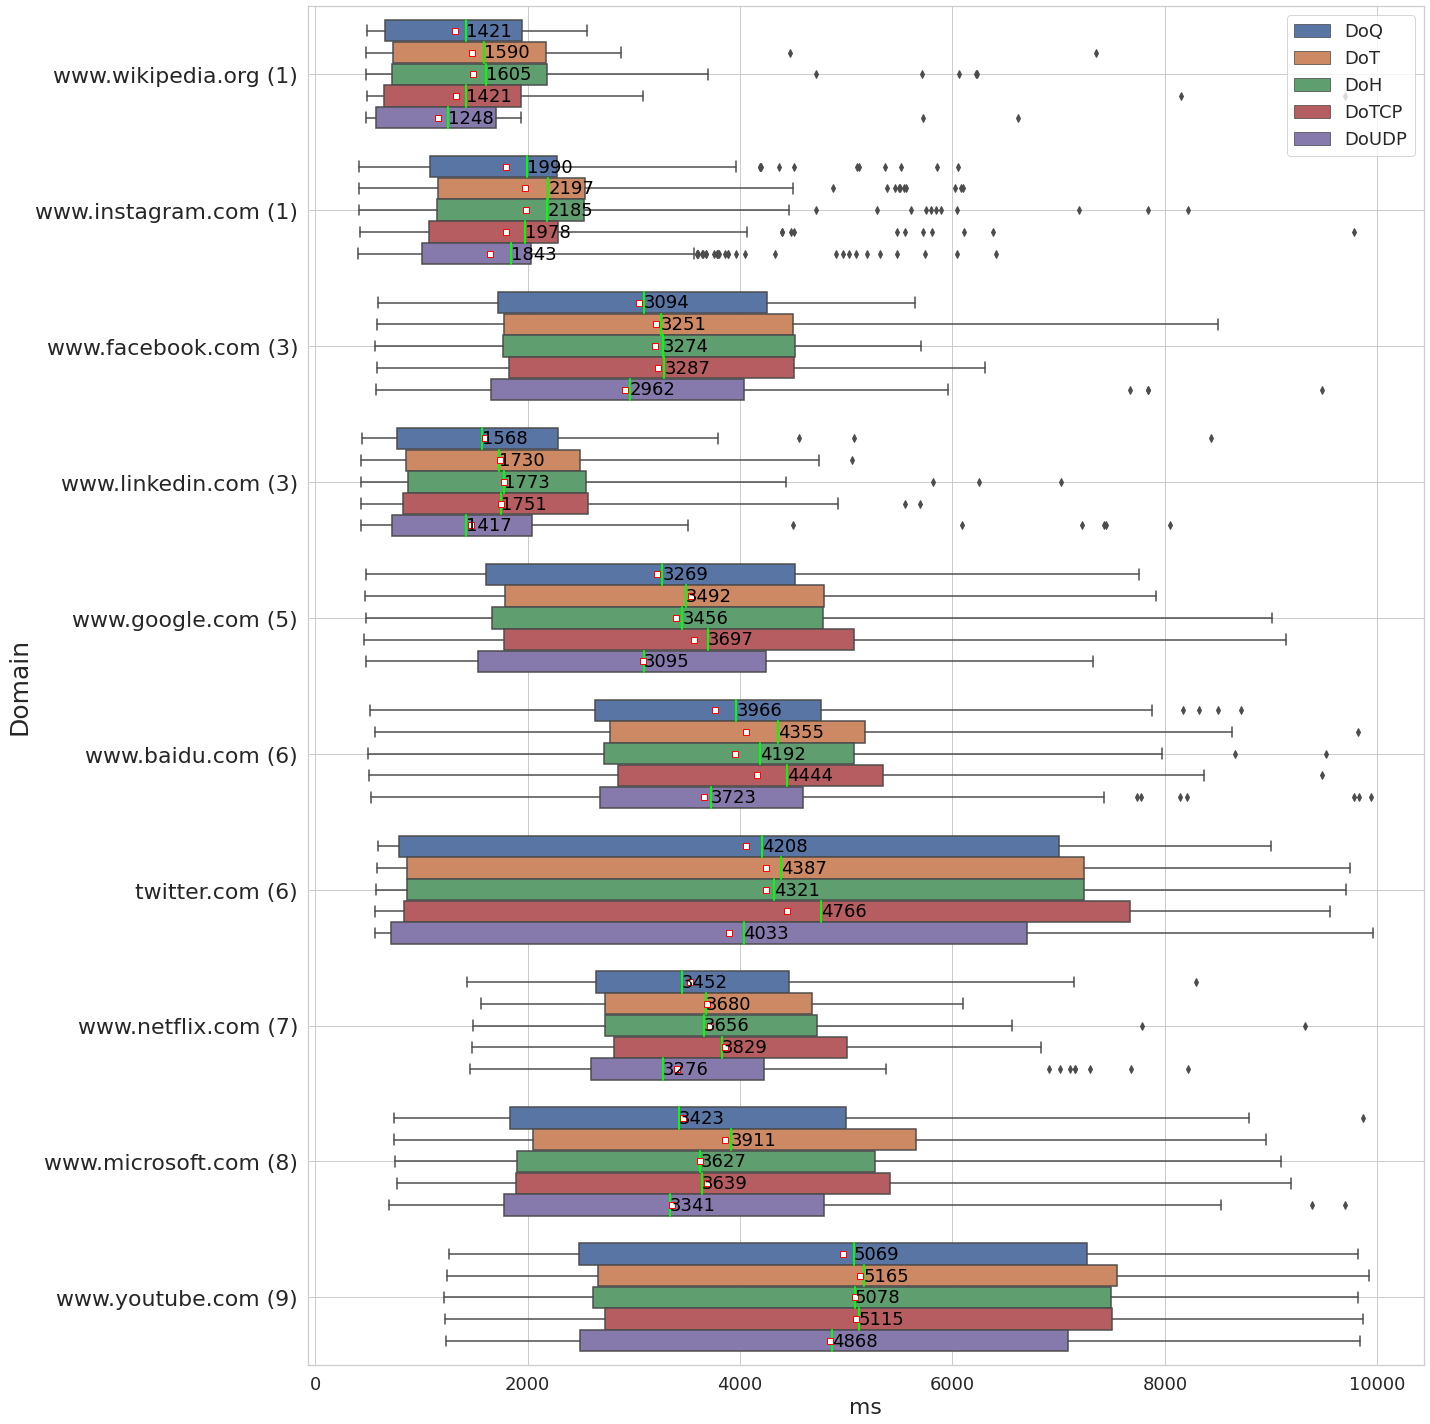

**Africa South**

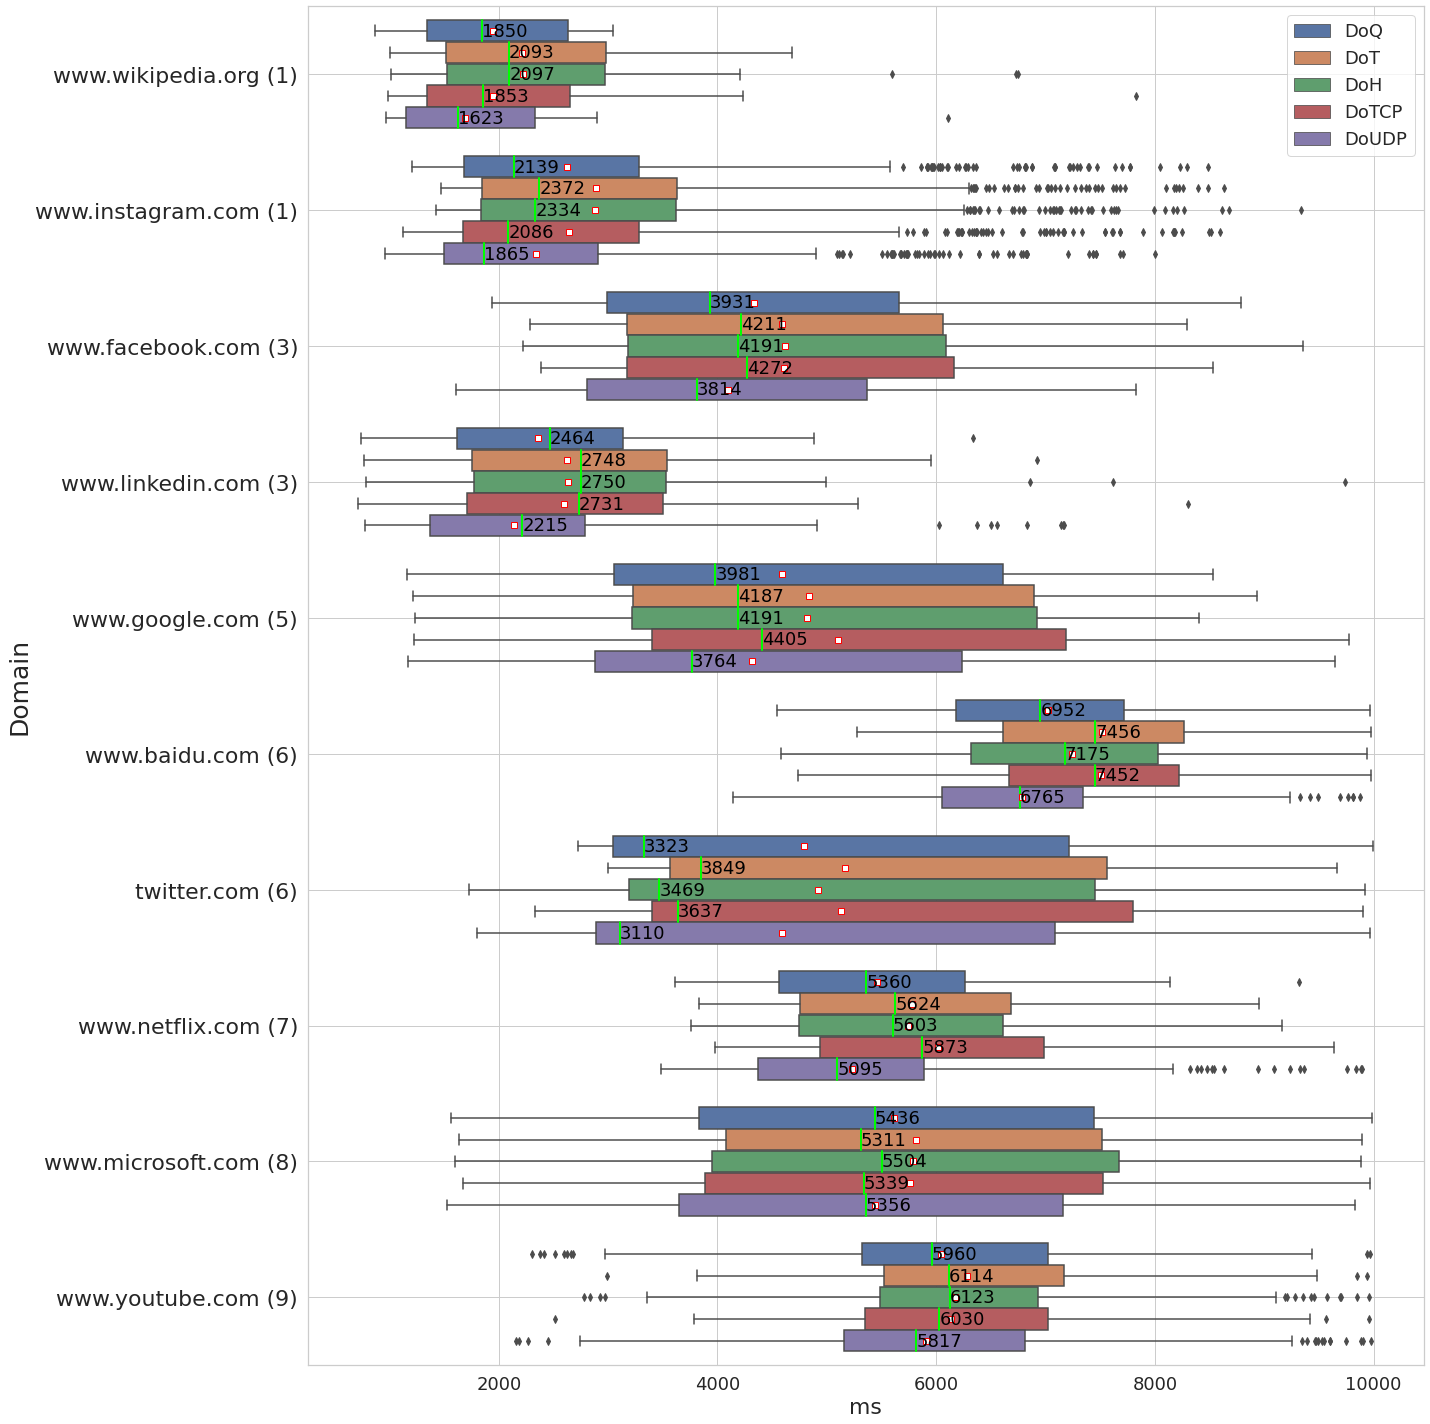

In [900]:
printmd(f"***Domain Comparison ordered by Number of Queries (Load Event Start)***")

plt.rcParams["figure.figsize"] = (20,25)
for vantagePoint in vp_order:
    multiCompare('vantagePoint', vantagePoint, 'domain', ['loadEventStart'], ylabel='Domain', showfliers=True)

**www.netflix.com**

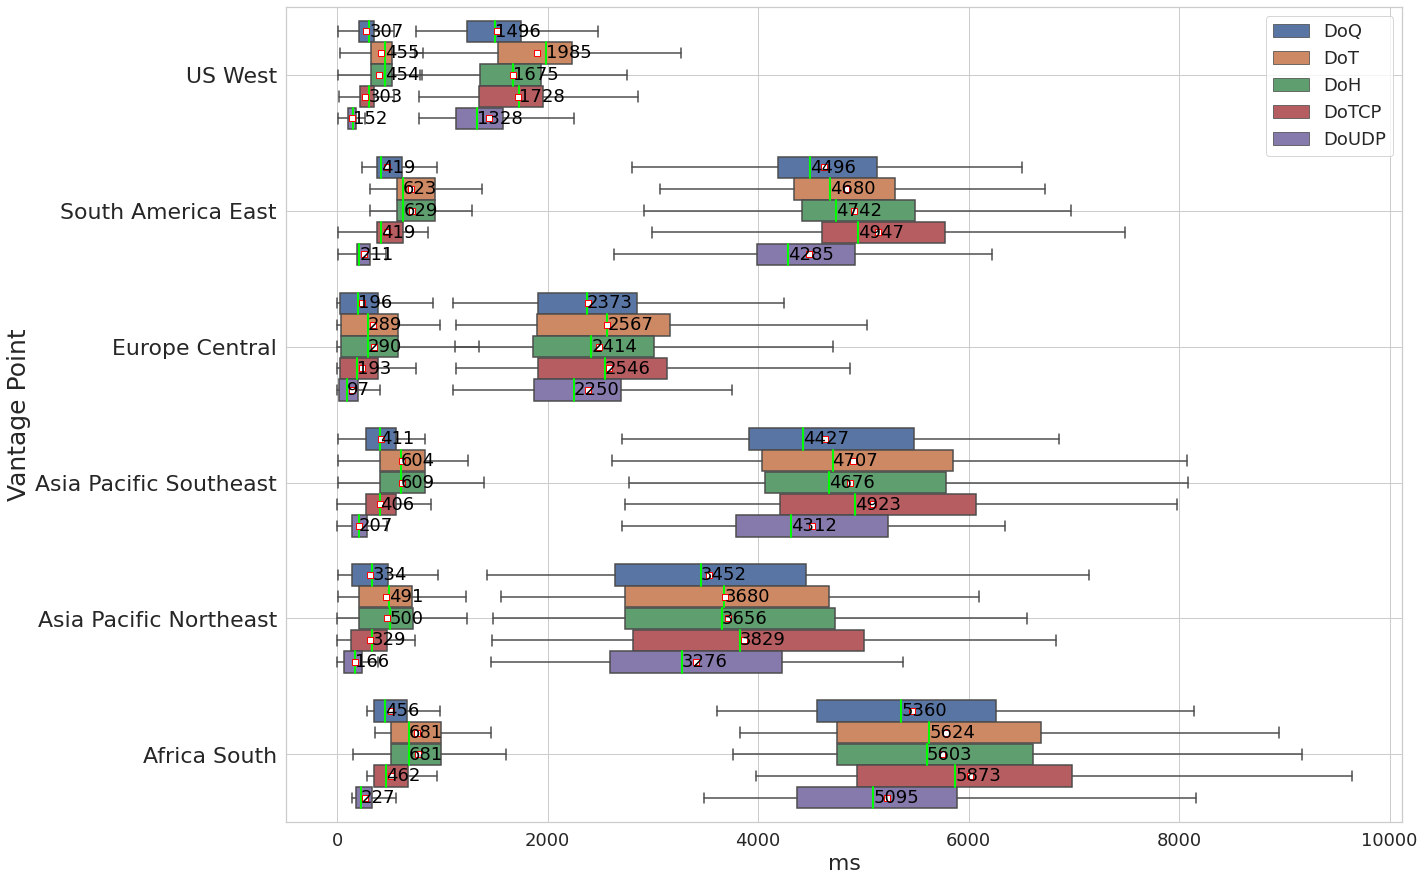

In [635]:
plt.rcParams["figure.figsize"] = (20,15)
multiCompare('domain', 'www.netflix.com', 'vantagePoint', ['elapsed', 'loadEventStart'], ylabel='Vantage Point')

## Inspecting Error Rates

In [643]:
# measurement samples
df.groupby(['vantagePoint', 'protocol']).size().unstack()

protocol,HTTPS,QUIC,TCP,TLS,UDP
vantagePoint,,,,,
Africa South,9017,9137,8894,8798,9104
Asia Pacific Northeast,9838,9902,9794,9837,9819
Asia Pacific Southeast,9237,9370,9028,9151,9351
Europe Central,9809,9885,9811,9796,9807
South America East,9043,9147,9027,8948,9110
US West,9896,9952,9874,9910,9841


In [644]:
# queries
df[['vantagePoint', 'queries', 'protocol']].groupby(['vantagePoint', 'protocol']).sum().unstack()

queries                            
protocol                 HTTPS   QUIC    TCP    TLS    UDP
vantagePoint                                              
Africa South             47106  44152  46855  45649  47654
Asia Pacific Northeast   54175  51724  53750  54448  53757
Asia Pacific Southeast   47619  45184  47176  47149  48194
Europe Central           43577  43111  43837  43825  43528
South America East       45665  42911  46225  45188  45895
US West                  52857  50523  53838  53461  51943

In [667]:
query = """
SELECT id, server, protocol, vantagePoint, error FROM measurements WHERE (error != '' OR decodedBodySize == 0) AND error NOT LIKE 'Message: timeout%' AND vantagePoint != 'US East';
"""
df_errors = pd.read_sql(query, connection, index_col="id")
df_tmp = df_errors[~df_errors.server.isin(servers_to_exclude)].copy()
df_errors = df_tmp

In [668]:
query = """
SELECT id, protocol, server, vantagePoint, error FROM measurements WHERE error LIKE 'Message: timeout%' AND vantagePoint != 'US East';
"""
df_timeouts = pd.read_sql(query, connection, index_col="id")
df_tmp = df_timeouts[~df_timeouts.server.isin(servers_to_exclude)].copy()
df_timeouts = df_tmp

In [697]:
query = """
SELECT id, protocol, server, vantagePoint, error FROM measurements WHERE (error != '' OR decodedBodySize == 0) AND vantagePoint != 'US East';
"""
df_all_errors = pd.read_sql(query, connection, index_col="id")
df_tmp = df_all_errors[~df_all_errors.server.isin(servers_to_exclude)].copy()
df_all_errors = df_tmp

In [698]:
query = """
SELECT id, server, protocol, vantagePoint, error, decodedBodySize FROM measurements WHERE vantagePoint != 'US East' AND ((cacheWarming == 0) OR ((cacheWarming == 1 AND (error != '' OR decodedBodySize == 0))));
"""
df_all = pd.read_sql(query, connection, index_col="id")
df_tmp = df_all[~df_all.server.isin(servers_to_exclude)].copy()
df_all = df_tmp

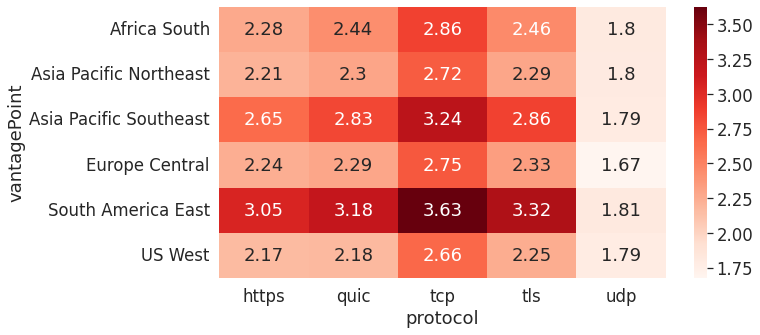

In [671]:
# non timeout errors %
plt.rcParams["figure.figsize"] = (10,5)
x = df_errors.groupby(['vantagePoint', 'protocol']).size().unstack() / df_all.groupby(['vantagePoint', 'protocol']).size().unstack() * 100
sns.heatmap(x, annot=True, fmt='.3g', cmap='Reds')
plt.show()

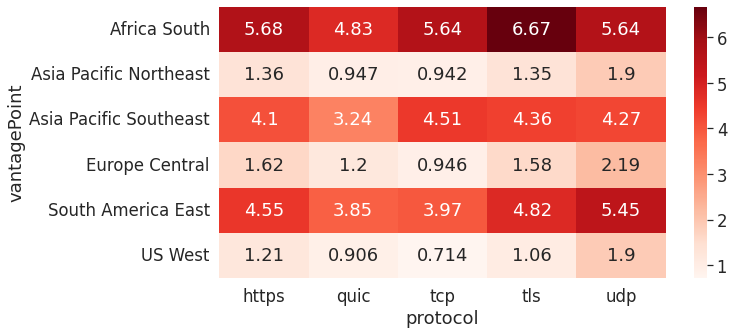

In [672]:
# timeouts %
x = df_timeouts.groupby(['vantagePoint', 'protocol']).size().unstack() / df_all.groupby(['vantagePoint', 'protocol']).size().unstack() * 100
sns.heatmap(x, annot=True, fmt='.3g', cmap='Reds')
plt.show()

In [699]:
df_all_errors.groupby(['protocol']).size()

protocol
https    6617
quic     6059
tcp      6872
tls      7027
udp      6417
dtype: int64

In [700]:
df_all_errors.groupby(['protocol']).size() / df_all.groupby(['protocol']).size() * 100

protocol
https    10.427534
quic      9.548950
tcp      10.856240
tls      11.071896
udp      10.113635
dtype: float64

In [513]:
df_all[(df_all['error'] == '') & (df_all['decodedBodySize'] != 0)].groupby(['server', 'vantagePoint']).size().unstack()

vantagePoint,Africa South,Asia Pacific Northeast,Asia Pacific Southeast,Europe Central,South America East,US East,US West
server,,,,,,,
101.32.27.77,180.0,200.0,197.0,199.0,180.0,198.0,200.0
103.105.98.141,149.0,200.0,200.0,192.0,151.0,197.0,199.0
103.123.108.197,120.0,199.0,189.0,184.0,121.0,187.0,189.0
103.124.95.99,152.0,199.0,199.0,199.0,152.0,199.0,200.0
103.172.17.225,151.0,198.0,198.0,183.0,157.0,191.0,197.0
...,...,...,...,...,...,...,...
94.140.14.49,200.0,200.0,199.0,200.0,200.0,200.0,200.0
94.140.14.59,199.0,200.0,200.0,200.0,198.0,200.0,200.0
94.140.15.15,198.0,200.0,199.0,200.0,198.0,200.0,200.0


In [519]:
df_all[(df_all['error'] == '') & (df_all['decodedBodySize'] != 0)].groupby(['server', 'protocol']).size().unstack()

protocol,https,quic,tcp,tls,udp
server,,,,,
101.32.27.77,272.0,273.0,267.0,266.0,276.0
103.105.98.141,262.0,260.0,255.0,252.0,259.0
103.123.108.197,251.0,253.0,247.0,250.0,188.0
103.124.95.99,261.0,261.0,255.0,259.0,264.0
103.172.17.225,255.0,262.0,251.0,253.0,254.0
...,...,...,...,...,...
94.140.14.49,280.0,280.0,279.0,280.0,280.0
94.140.14.59,279.0,280.0,279.0,279.0,280.0
94.140.15.15,278.0,280.0,279.0,280.0,278.0


In [516]:
df_success_protocols = df_all[(df_all['error'] == '') & (df_all['decodedBodySize'] != 0)].groupby(['server', 'protocol']).size().unstack()

In [591]:
df_tmp = (df_success_protocols.pct_change(axis=1, periods=-1) * 100).abs()
df_tmp2 = (df_success_protocols.pct_change(axis=1, periods=1) * 100).abs()

In [588]:
t = 25
t2 = 50

In [589]:
df_success_protocols[(df_success_protocols['tcp'] < t2) | (df_success_protocols['tls'] < t2) | (df_success_protocols['udp'] < t2) | (df_success_protocols['quic'] < t2) | (df_success_protocols['https'] < t2)]

protocol,https,quic,tcp,tls,udp
server,,,,,
199.101.171.125,109.0,116.0,122.0,4.0,123.0
37.114.32.80,273.0,14.0,270.0,276.0,265.0
47.243.237.126,NaN,1.0,1.0,NaN,NaN
62.109.2.197,28.0,29.0,22.0,25.0,19.0
93.115.24.205,237.0,236.0,225.0,202.0,6.0


In [593]:
servers_to_exclude = ['199.101.171.125', '37.114.32.80', '47.243.237.126', '93.115.24.205']

In [592]:
list_tmp = df_tmp[(df_tmp['tcp'] > t) | (df_tmp['tls'] > t) | (df_tmp['udp'] > t) | (df_tmp['quic'] > t) | (df_tmp['https'] > t)].index.tolist()
list_tmp2 = df_tmp2[(df_tmp2['tcp'] > t) | (df_tmp2['tls'] > t) | (df_tmp2['udp'] > t) | (df_tmp2['quic'] > t) | (df_tmp2['https'] > t)].index.tolist()
bad_servers = list(set(list_tmp + list_tmp2))
print(bad_servers)

['43.132.147.94', '42.192.89.119', '120.55.44.44', '103.227.141.70', '199.101.171.125', '103.123.108.197', '113.31.103.21', '37.114.32.80', '47.107.121.125', '62.109.2.197', '106.12.119.30', '93.115.24.205', '185.254.18.242', '103.232.207.3']


In [522]:
df_success_protocols[(df_success_protocols['tcp'] < 200) | (df_success_protocols['tls'] < 200) | (df_success_protocols['udp'] < 200) | (df_success_protocols['quic'] < 200) | (df_success_protocols['https'] < 200)]

protocol,https,quic,tcp,tls,udp
server,,,,,
103.123.108.197,251.0,253.0,247.0,250.0,188.0
103.172.17.226,179.0,181.0,178.0,175.0,182.0
103.232.207.3,191.0,276.0,272.0,273.0,275.0
104.168.11.116,139.0,139.0,139.0,139.0,140.0
106.12.119.30,152.0,164.0,93.0,116.0,94.0
113.31.103.21,134.0,136.0,103.0,133.0,121.0
119.23.190.32,105.0,101.0,98.0,103.0,99.0
119.3.92.152,113.0,109.0,102.0,106.0,103.0
120.55.44.44,262.0,261.0,108.0,246.0,107.0


In [585]:
servers_to_exclude += ['120.55.44.44', '199.101.171.125', '203.160.55.187', '37.114.32.80', '43.132.147.94', '47.107.121.125', '47.243.237.126', '93.115.24.205']

In [558]:
df_success_protocols[df_success_protocols.index.isin(bad_servers)]

protocol,https,quic,tcp,tls,udp
server,,,,,
103.123.108.197,251.0,253.0,247.0,250.0,188.0
103.227.141.70,266.0,268.0,208.0,263.0,207.0
103.232.207.3,191.0,276.0,272.0,273.0,275.0
106.12.119.30,152.0,164.0,93.0,116.0,94.0
113.31.103.21,134.0,136.0,103.0,133.0,121.0
120.55.44.44,262.0,261.0,108.0,246.0,107.0
185.254.18.242,263.0,267.0,258.0,191.0,265.0
199.101.171.125,109.0,116.0,122.0,4.0,123.0
37.114.32.80,273.0,14.0,270.0,276.0,265.0


In [518]:
df_success_servers = df_all[(df_all['error'] == '') & (df_all['decodedBodySize'] != 0)].groupby(['server', 'vantagePoint']).size().unstack()

In [598]:
df_tmp = (df_success_servers.pct_change(axis=1, periods=-1) * 100).abs()
df_tmp2 = (df_success_servers.pct_change(axis=1, periods=1) * 100).abs()

In [604]:
t=100
t2=50

In [583]:
# servers with generally low samplesize
df_success_servers[(df_success_servers['Africa South'] < t2) | (df_success_servers['Asia Pacific Northeast'] < t2) | (df_success_servers['Asia Pacific Southeast'] < t2) | (df_success_servers['Europe Central'] < t2) | (df_success_servers['South America East'] < t2) | (df_success_servers['US East'] < t2) | (df_success_servers['US West'] < t2)]

vantagePoint,Africa South,Asia Pacific Northeast,Asia Pacific Southeast,Europe Central,South America East,US East,US West
server,,,,,,,
168.138.163.222,38.0,50.0,100.0,98.0,49.0,49.0,30.0
188.166.237.128,35.0,45.0,45.0,45.0,34.0,44.0,45.0
188.72.209.168,49.0,50.0,46.0,50.0,50.0,50.0,49.0
203.160.55.187,22.0,30.0,29.0,30.0,23.0,NaN,30.0
45.82.178.72,50.0,50.0,46.0,50.0,50.0,50.0,47.0
47.243.237.126,NaN,1.0,NaN,1.0,NaN,NaN,NaN
47.243.57.44,40.0,50.0,50.0,49.0,41.0,50.0,50.0
62.109.2.197,48.0,NaN,27.0,NaN,48.0,NaN,NaN


In [587]:
servers_to_exclude += ['203.160.55.187', '47.243.237.126', '62.109.2.197', '168.138.163.222']

In [605]:
list_tmp = df_tmp[(df_tmp['Africa South'] > t) | (df_tmp['Asia Pacific Northeast'] > t) | (df_tmp['Asia Pacific Southeast'] > t) | (df_tmp['Europe Central'] > t) | (df_tmp['South America East'] > t) | (df_tmp['US East'] > t) | (df_tmp['US West'] > t)].index.tolist()
list_tmp2 = df_tmp2[(df_tmp2['Africa South'] > t) | (df_tmp2['Asia Pacific Northeast'] > t) | (df_tmp2['Asia Pacific Southeast'] > t) | (df_tmp2['Europe Central'] > t) | (df_tmp2['South America East'] > t) | (df_tmp2['US East'] > t) | (df_tmp2['US West'] > t)].index.tolist()
bad_servers = list(set(list_tmp + list_tmp2))
print(bad_servers)

['202.61.207.68', '138.2.86.147', '93.115.24.205', '103.176.79.211']


In [606]:
df_success_servers[df_success_servers.index.isin(bad_servers)]

vantagePoint,Africa South,Asia Pacific Northeast,Asia Pacific Southeast,Europe Central,South America East,US East,US West
server,,,,,,,
103.176.79.211,66.0,190.0,184.0,168.0,133.0,184.0,180.0
138.2.86.147,167.0,184.0,187.0,185.0,165.0,90.0,185.0
202.61.207.68,199.0,97.0,160.0,200.0,198.0,199.0,200.0
93.115.24.205,149.0,140.0,105.0,158.0,66.0,144.0,144.0


In [607]:
servers_to_exclude += ['103.176.79.211', '138.2.86.147', '202.61.207.68', '93.115.24.205']

In [608]:
servers_to_exclude = list(set(servers_to_exclude))
print(len(servers_to_exclude))
print(servers_to_exclude)

13
['138.2.86.147', '43.132.147.94', '120.55.44.44', '199.101.171.125', '202.61.207.68', '168.138.163.222', '203.160.55.187', '37.114.32.80', '103.176.79.211', '47.107.121.125', '47.243.237.126', '93.115.24.205', '62.109.2.197']


## Plots

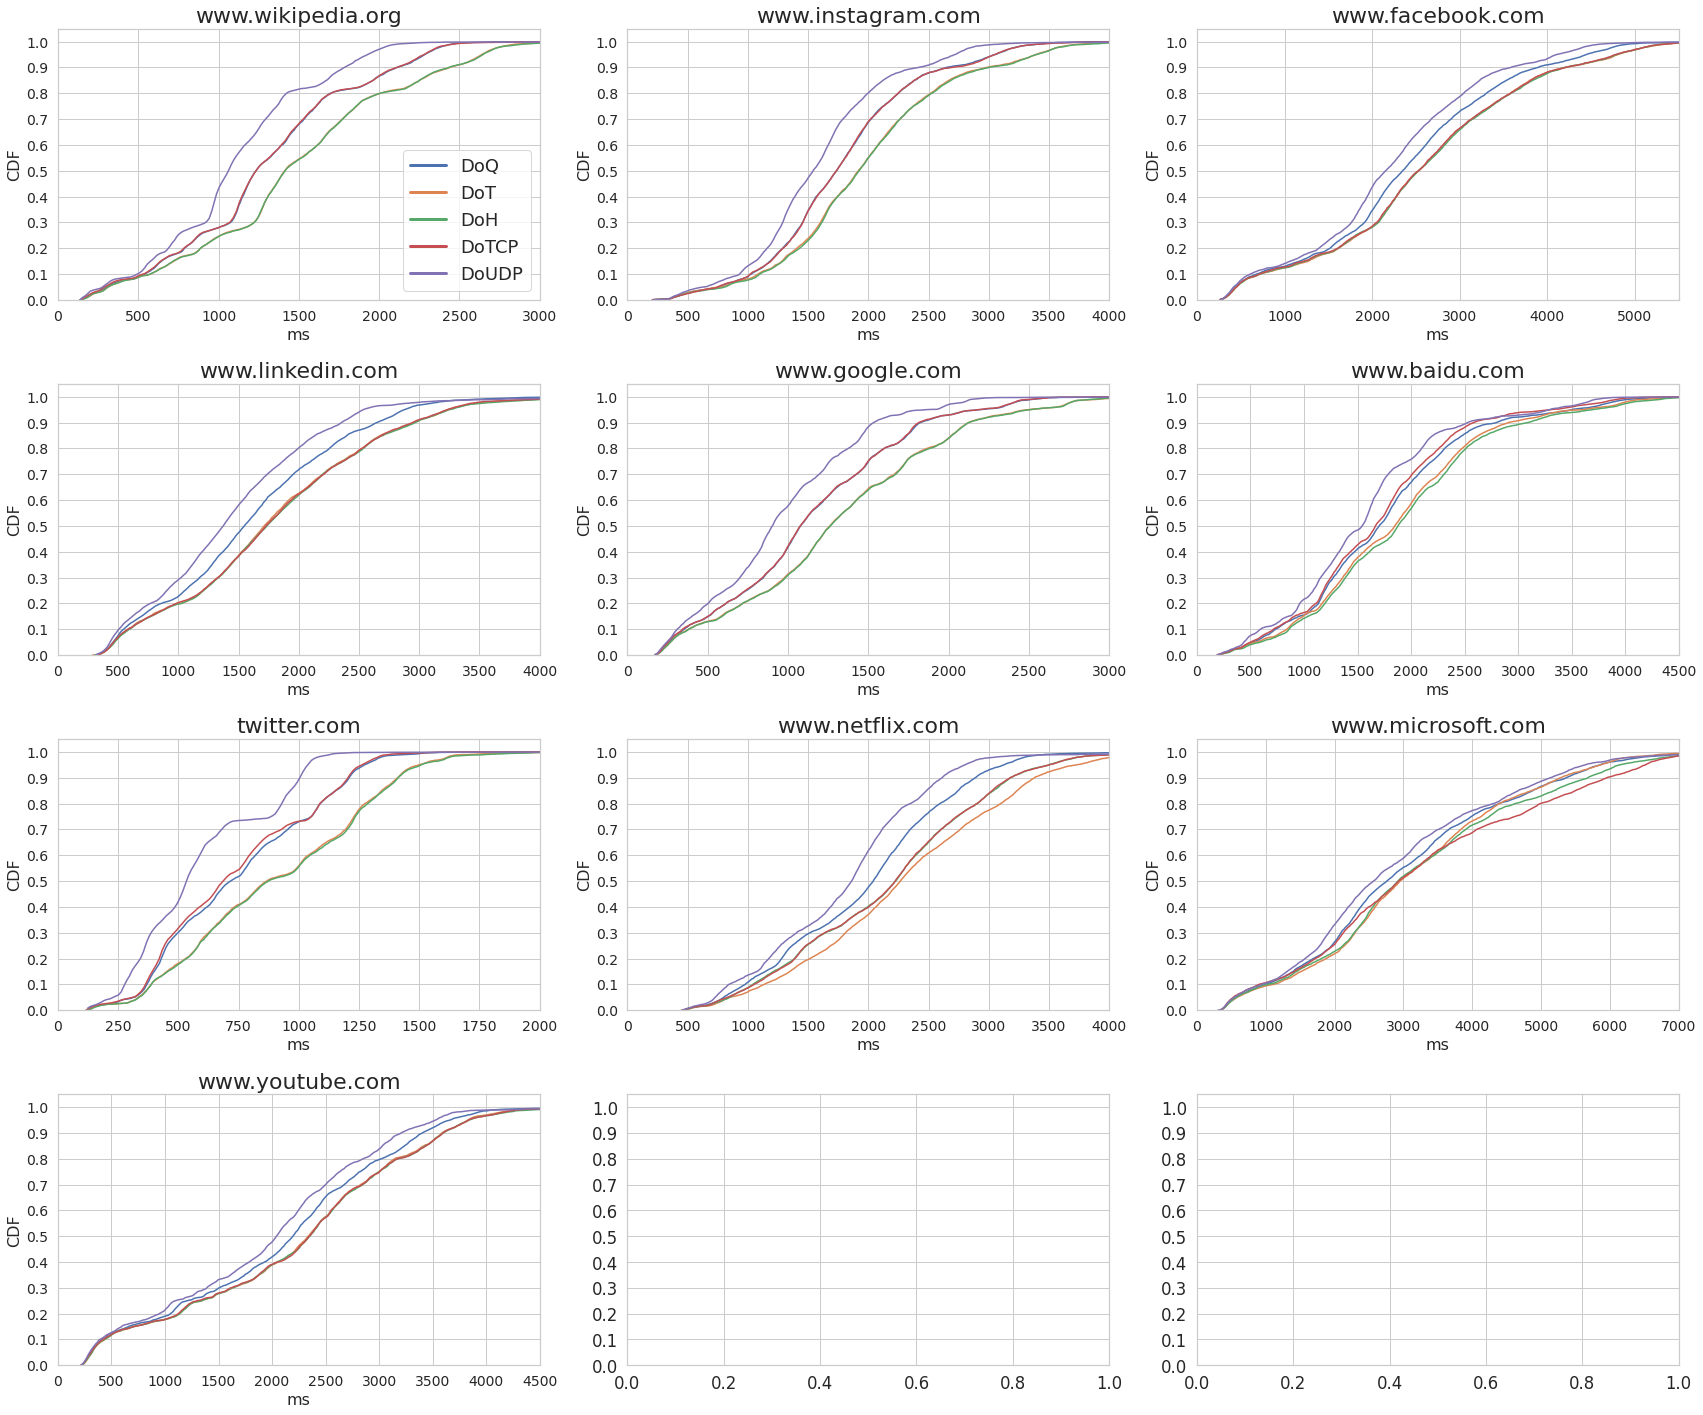

In [645]:
# FCP CDF
i = 0
fig, axs = plt.subplots(4, 3, figsize=(24, 20), sharey='col')
axes = []
times = {}

for domain in domain_order:
    dom_df = df[df['domain'] == domain]
    dom_df = dom_df[dom_df['firstContentfulPaint'] > 0]
    for protocol in protocols:
        times[protocol] = dom_df[dom_df['protocol'] == protocol]['firstContentfulPaint']
    ax = axs[int(i/3),i%3]
    sns.lineplot(x=calculateCDF(times['QUIC'])[0], y=calculateCDF(times['QUIC'])[1], label="DoQ", ax=ax)
    sns.lineplot(x=calculateCDF(times['TLS'])[0], y=calculateCDF(times['TLS'])[1], label="DoT", ax=ax)
    sns.lineplot(x=calculateCDF(times['HTTPS'])[0], y=calculateCDF(times['HTTPS'])[1], label="DoH", ax=ax)
    sns.lineplot(x=calculateCDF(times['TCP'])[0], y=calculateCDF(times['TCP'])[1], label="DoTCP", ax=ax)
    sns.lineplot(x=calculateCDF(times['UDP'])[0], y=calculateCDF(times['UDP'])[1], label="DoUDP", ax=ax)

    ax.set_xlabel("ms", fontsize = 16)
    ax.set_ylabel("CDF", fontsize = 16)
    ax.tick_params(labelleft=True)
    ax.tick_params(labelbottom=True)
    ax.set_title(domain, fontsize = 22)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_ylim(0.0, 1.05)
    ax.yaxis.set_ticks(np.arange(0.0, 1.01, 0.1))
    
    switcher = {
        'www.netflix.com': 4000,
        'www.google.com': 3000,
        'www.youtube.com': 4500,
        'www.facebook.com': 5500,
        'twitter.com': 2000,
        'www.instagram.com': 4000,
        'www.linkedin.com': 4000,
        'www.wikipedia.org': 3000,
        'www.baidu.com': 4500,
        'www.microsoft.com': 7000
    }
    ax.set_xlim(0, switcher.get(domain, 5000))
    
    if i == 11 or i == 0:
        leg = ax.legend(loc="lower right", fontsize='medium')
        for line in leg.get_lines():
            line.set_linewidth(3.0)
    else:
        ax.get_legend().remove()
    fig.tight_layout()
    ax.grid(True)

    i += 1
plt.savefig("figures/domains-cdf.pdf", bbox_inches='tight')
plt.show()

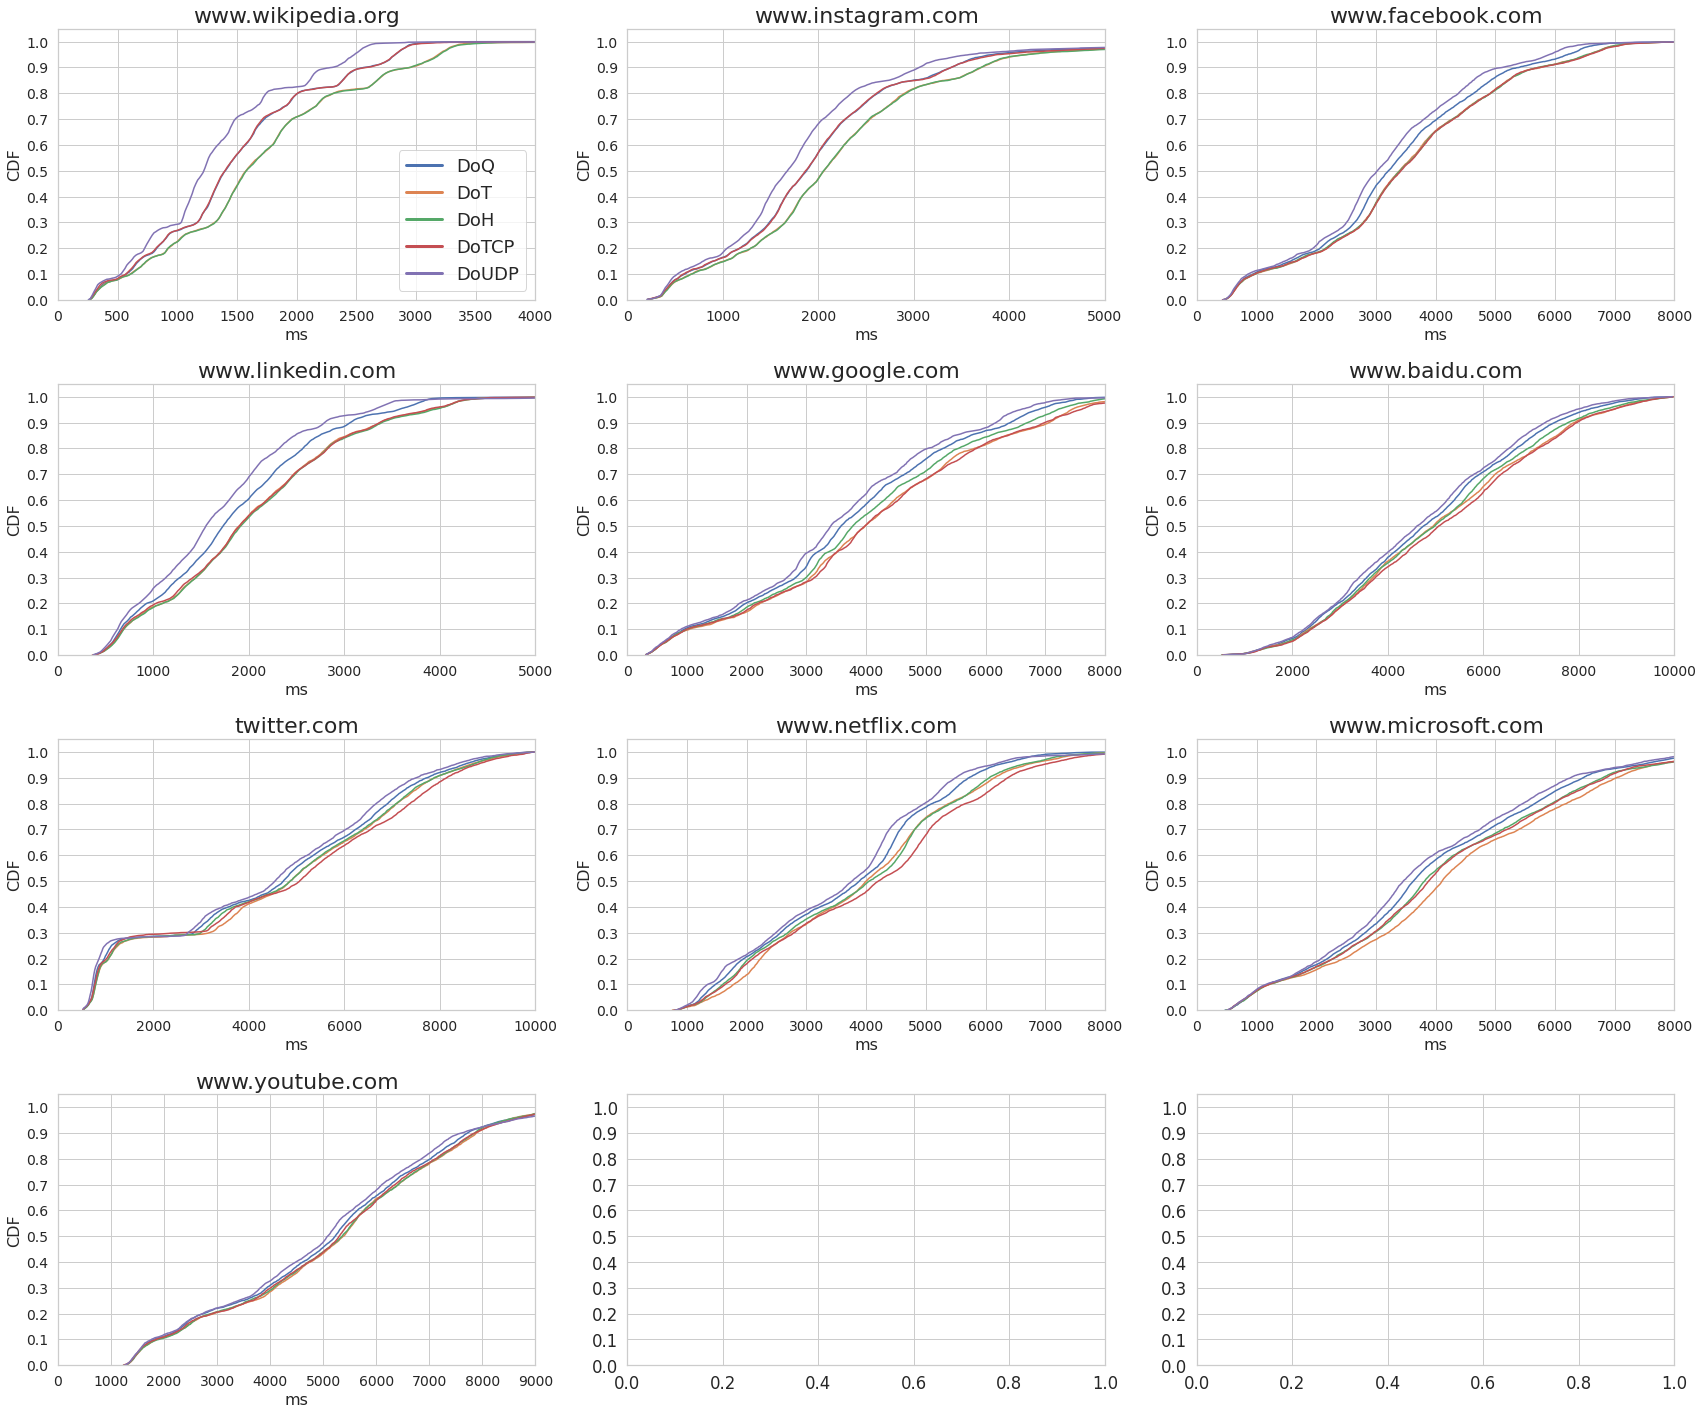

In [646]:
# PLT CDF
i = 0
fig, axs = plt.subplots(4, 3, figsize=(24, 20), sharey='col')
axes = []
times = {}

for domain in domain_order:
    dom_df = df[df['domain'] == domain]
    for protocol in protocols:
        times[protocol] = dom_df[dom_df['protocol'] == protocol]['loadEventStart']
    ax = axs[int(i/3),i%3]
    sns.lineplot(x=calculateCDF(times['QUIC'])[0], y=calculateCDF(times['QUIC'])[1], label="DoQ", ax=ax)
    sns.lineplot(x=calculateCDF(times['TLS'])[0], y=calculateCDF(times['TLS'])[1], label="DoT", ax=ax)
    sns.lineplot(x=calculateCDF(times['HTTPS'])[0], y=calculateCDF(times['HTTPS'])[1], label="DoH", ax=ax)
    sns.lineplot(x=calculateCDF(times['TCP'])[0], y=calculateCDF(times['TCP'])[1], label="DoTCP", ax=ax)
    sns.lineplot(x=calculateCDF(times['UDP'])[0], y=calculateCDF(times['UDP'])[1], label="DoUDP", ax=ax)

    ax.set_xlabel("ms", fontsize = 16)
    ax.set_ylabel("CDF", fontsize = 16)
    ax.tick_params(labelleft=True)
    ax.tick_params(labelbottom=True)
    ax.set_title(domain, fontsize = 22)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_ylim(0.0, 1.05)
    ax.yaxis.set_ticks(np.arange(0.0, 1.01, 0.1))
    
    switcher = {
        'www.netflix.com': 8000,
        'www.google.com': 8000,
        'www.youtube.com': 9000,
        'www.facebook.com': 8000,
        'twitter.com': 10000,
        'www.instagram.com': 5000,
        'www.linkedin.com': 5000,
        'www.wikipedia.org': 4000,
        'www.baidu.com': 10000,
        'www.microsoft.com': 8000
    }
    ax.set_xlim(0, switcher.get(domain, 5000))
    
    if i == 11 or i == 0:
        leg = ax.legend(loc="lower right", fontsize='medium')
        for line in leg.get_lines():
            line.set_linewidth(3.0)
    else:
        ax.get_legend().remove()
    fig.tight_layout()
    ax.grid(True)

    i += 1
#plt.savefig("figures/domains-cdf.pdf", bbox_inches='tight')
plt.show()

In [890]:
# Difference between DoH and DoQ/DoT/DoUDP
diff_dict = {'domain': [], 'vantagePoint': [], 'server': [], 'QUIC-PLT': [], 'QUIC-FCP': [], 'TLS-PLT': [], 'TLS-FCP': [], 'UDP-PLT': [], 'UDP-FCP': [], 'RTT_over_10ms': []}

for vp in vp_order:
    print(vp)
    df_vp = df[df['vantagePoint'] == vp].copy()
    for server in df_vp['server'].unique():
        df_server = df_vp[df_vp['server'] == server].copy()
        for domain in domain_order:
            df_domain = df_server[df_server['domain'] == domain].copy()
            
            start_date = date(2022, 4, 18)
            end_date = date(2022, 4, 24)
            delta = timedelta(days=2)
            df_domain['timestamp'] = pd.to_datetime(df_domain['timestamp']).dt.date
            
            # we remove iterations with faulty measurements
            while start_date <= end_date:
                df_timeframe = df_domain[(df_domain['timestamp'] >= start_date) & (df_domain['timestamp'] < (start_date+delta))].copy()
                
                tmp_list = []
                for protocol in ['UDP', 'QUIC', 'TLS', 'HTTPS', 'TCP']:
                    df_protocol = df_timeframe[df_timeframe['protocol'] == protocol].copy()
                    tmp_list += df_protocol['firstContentfulPaint'].tolist()
                    tmp_list += df_protocol['loadEventEnd'].tolist()
                    
                if 0.0 in tmp_list or np.nan in tmp_list:
                    df_domain = df_domain[(df_domain['timestamp'] < start_date) | (df_domain['timestamp'] >= (start_date+delta))]
                start_date += delta
                
            df_doh = df_domain[df_domain['protocol'] == 'HTTPS'].copy()
            if not df_doh.empty:
                # doh baseline
                mean_plt_doh = df_doh['loadEventStart'].mean()
                mean_fcp_doh = df_doh['firstContentfulPaint'].mean()
                
                # add vantage point, server and domain information
                diff_dict['vantagePoint'].append(vp)
                diff_dict['domain'].append(domain)
                diff_dict['server'].append(server)
                
                # add PLT and FCP increase
                for protocol in ['QUIC', 'TLS', 'UDP']:
                    df_protocol = df_domain[df_domain['protocol'] == protocol].copy()
                    mean_plt_protocol = df_protocol['loadEventStart'].mean()
                    mean_fcp_protocol = df_protocol['firstContentfulPaint'].mean()
                    
                    increase_plt = (mean_plt_protocol/(mean_plt_doh/100))-100
                    increase_fcp = (mean_fcp_protocol/(mean_fcp_doh/100))-100
                    
                    diff_dict[f"{protocol}-PLT"].append(increase_plt)
                    diff_dict[f"{protocol}-FCP"].append(increase_fcp)
                    
                # add information if resolver rtt is over 10 ms
                df_dou = df_domain[df_domain['protocol'] == 'UDP'].copy()
                mean_rtt = df_dou['avg_lookup_end'].mean()
                diff_dict['RTT_over_10ms'].append(mean_rtt > 10)
                
diff_df = pd.DataFrame.from_dict(diff_dict)

diff_df.rename(columns={"QUIC-PLT": "DoQ-PLT", "QUIC-FCP": "DoQ-FCP", "TLS-PLT": "DoT-PLT", "TLS-FCP": "DoT-FCP",
                        "UDP-PLT": "DoUDP-PLT", "UDP-FCP": "DoUDP-FCP"}, inplace=True)

US West
South America East
Europe Central
Asia Pacific Southeast
Asia Pacific Northeast
Africa South


In [887]:
# Difference between DoUDP and DoQ/DoT/DoH/DoTCP
diff_dict2 = {'domain': [], 'vantagePoint': [], 'server': [], 'QUIC-PLT': [], 'QUIC-FCP': [], 'TLS-PLT': [], 'TLS-FCP': [], 
             'HTTPS-PLT': [], 'HTTPS-FCP': [], 'TCP-PLT': [], 'TCP-FCP': [], 'RTT_over_10ms': []}

for vp in vp_order:
    print(vp)
    df_vp = df[df['vantagePoint'] == vp].copy()
    for server in df_vp['server'].unique():
        df_server = df_vp[df_vp['server'] == server].copy()
        for domain in domain_order:
            df_domain = df_server[df_server['domain'] == domain].copy()
            
            start_date = date(2022, 4, 18)
            end_date = date(2022, 4, 24)
            delta = timedelta(days=2)
            df_domain['timestamp'] = pd.to_datetime(df_domain['timestamp']).dt.date
            
            # we remove iterations with faulty measurements
            while start_date <= end_date:
                df_timeframe = df_domain[(df_domain['timestamp'] >= start_date) & (df_domain['timestamp'] < (start_date+delta))].copy()
                
                tmp_list = []
                for protocol in ['UDP', 'QUIC', 'TLS', 'HTTPS', 'TCP']:
                    df_protocol = df_timeframe[df_timeframe['protocol'] == protocol].copy()
                    tmp_list += df_protocol['firstContentfulPaint'].tolist()
                    tmp_list += df_protocol['loadEventEnd'].tolist()
                    
                if 0.0 in tmp_list or np.nan in tmp_list:
                    df_domain = df_domain[(df_domain['timestamp'] < start_date) | (df_domain['timestamp'] >= (start_date+delta))]
                start_date += delta
            
            df_udp = df_domain[df_domain['protocol'] == 'UDP'].copy()
            if not df_udp.empty:
                # udp baseline
                mean_plt_udp = df_udp['loadEventStart'].mean()
                mean_fcp_udp = df_udp['firstContentfulPaint'].mean()
                mean_rtt = df_udp['avg_lookup_end'].mean()
                # add PLT and FCP increase
                for protocol in ['QUIC', 'TLS', 'HTTPS', 'TCP']:
                    df_protocol = df_domain[df_domain['protocol'] == protocol].copy()
                    mean_plt_protocol = df_protocol['loadEventStart'].mean()
                    mean_fcp_protocol = df_protocol['firstContentfulPaint'].mean()

                    increase_plt = (mean_plt_protocol/(mean_plt_udp/100))-100
                    increase_fcp = (mean_fcp_protocol/(mean_fcp_udp/100))-100

                    diff_dict2[f"{protocol}-PLT"].append(increase_plt)
                    diff_dict2[f"{protocol}-FCP"].append(increase_fcp)

                # add vantage point, server and domain information
                diff_dict2['vantagePoint'].append(vp)
                diff_dict2['domain'].append(domain)
                diff_dict2['server'].append(server)
                # add information if resolver rtt is over 10 ms
                diff_dict2['RTT_over_10ms'].append(mean_rtt > 10)
                
diff_df2 = pd.DataFrame.from_dict(diff_dict2)

diff_df2.rename(columns={"QUIC-PLT": "DoQ-PLT", "QUIC-FCP": "DoQ-FCP", "TLS-PLT": "DoT-PLT", "TLS-FCP": "DoT-FCP",
                        "HTTPS-PLT": "DoH-PLT", "HTTPS-FCP": "DoH-FCP", "TCP-PLT": "DoTCP-PLT", "TCP-FCP": "DoTCP-FCP"}, inplace=True)

US West
South America East
Europe Central
Asia Pacific Southeast
Asia Pacific Northeast
Africa South


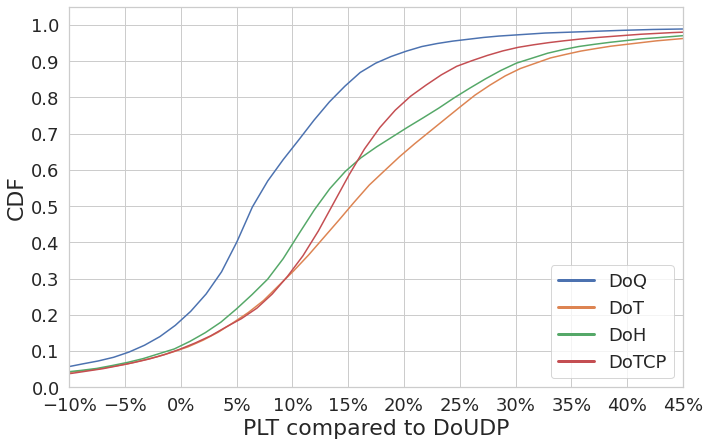

In [888]:
fig, ax = plt.subplots(figsize=(11, 7))
times = {}

for protocol in ['DoQ', 'DoT', 'DoH', 'DoTCP']:
    key = f'{protocol}-PLT'
    x = diff_df2[[key]].copy()
    x = x[x[key] < np.inf]
    x = x[~np.isnan(x)]
    times[protocol] = x

sns.lineplot(x=calculateCDF(times['DoQ'], bins=400)[0], y=calculateCDF(times['DoQ'], bins=400)[1], label="DoQ", ax=ax)
sns.lineplot(x=calculateCDF(times['DoT'], bins=400)[0], y=calculateCDF(times['DoT'], bins=400)[1], label="DoT", ax=ax)
sns.lineplot(x=calculateCDF(times['DoH'], bins=400)[0], y=calculateCDF(times['DoH'], bins=400)[1], label="DoH", ax=ax)
sns.lineplot(x=calculateCDF(times['DoTCP'], bins=400)[0], y=calculateCDF(times['DoTCP'], bins=400)[1], label="DoTCP", ax=ax)

ax.set_xlabel("PLT compared to DoUDP", fontsize = 22)
ax.set_ylabel("CDF", fontsize = 22)
ax.tick_params(labelleft=True)
ax.tick_params(labelbottom=True)
ax.tick_params(axis='both', labelsize=18)
ax.set_ylim(0.0, 1.05)
ax.yaxis.set_ticks(np.arange(0.0, 1.01, 0.1))

ax.set_xlim(-10, 40)
ax.xaxis.set_ticks(np.arange(-10, 46, 5))

ax.xaxis.set_major_formatter(mtick.PercentFormatter())

leg = ax.legend(loc="lower right", fontsize='medium')
for line in leg.get_lines():
    line.set_linewidth(3.0)

plt.savefig("figures/udp-baseline-plt.pdf", bbox_inches='tight')
plt.show()

In [899]:
def find_nearestx(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx
    
for protocol in ['DoQ']:
    key = f'{protocol}-PLT'
    x = diff_df2[[key]].copy()
    x = x[x[key] < np.inf]
    x = x[~np.isnan(x)]
    times[protocol] = x
    a, b = calculateCDF(times['DoQ'], bins=400)
    y = find_nearestx(b, 0.5)
    print(a[y])
    

6.410783674036182


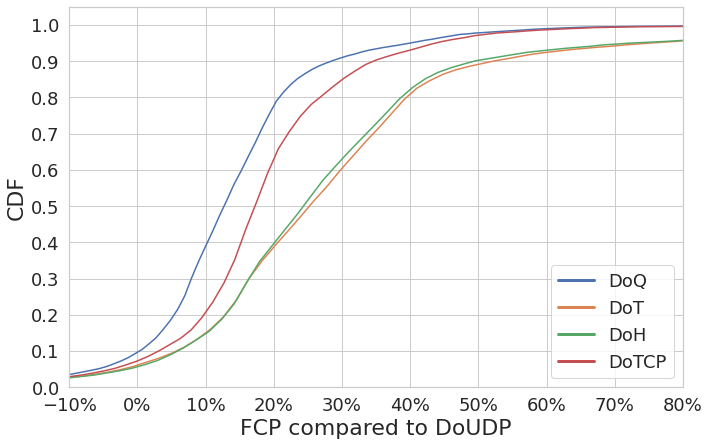

In [889]:
fig, ax = plt.subplots(figsize=(11, 7))
times = {}

for protocol in ['DoQ', 'DoT', 'DoH', 'DoTCP']:
    key = f'{protocol}-FCP'
    x = diff_df2[[key]].copy()
    x = x[x[key] < np.inf]
    x = x[~np.isnan(x)]
    times[protocol] = x

sns.lineplot(x=calculateCDF(times['DoQ'], bins=400)[0], y=calculateCDF(times['DoQ'], bins=400)[1], label="DoQ", ax=ax)
sns.lineplot(x=calculateCDF(times['DoT'], bins=400)[0], y=calculateCDF(times['DoT'], bins=400)[1], label="DoT", ax=ax)
sns.lineplot(x=calculateCDF(times['DoH'], bins=400)[0], y=calculateCDF(times['DoH'], bins=400)[1], label="DoH", ax=ax)
sns.lineplot(x=calculateCDF(times['DoTCP'], bins=400)[0], y=calculateCDF(times['DoTCP'], bins=400)[1], label="DoTCP", ax=ax)

ax.set_xlabel("FCP compared to DoUDP", fontsize = 22)
ax.set_ylabel("CDF", fontsize = 22)
ax.tick_params(labelleft=True)
ax.tick_params(labelbottom=True)
ax.tick_params(axis='both', labelsize=18)
ax.set_ylim(0.0, 1.05)
ax.yaxis.set_ticks(np.arange(0.0, 1.01, 0.1))

ax.set_xlim(-10, 60)
ax.xaxis.set_ticks(np.arange(-10, 81, 10))

ax.xaxis.set_major_formatter(mtick.PercentFormatter())

leg = ax.legend(loc="lower right", fontsize='medium')
for line in leg.get_lines():
    line.set_linewidth(3.0)

plt.savefig("figures/udp-baseline-fcp.pdf", bbox_inches='tight')
plt.show()

In [857]:
def create_comparison(data, ax, metric='PLT', baseline='DoUDP', compare_to='DoQ', compare_to_2=None):
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx
    
    key = f'{compare_to}-{metric}'
    x = data[[key]].copy()
    x = x[x[key] < np.inf]
    x = x[~np.isnan(x)]
    plot_x, plot_y = calculateCDF(x, bins=400)
    zero = find_nearest(plot_x, 0)
    sns.lineplot(x=plot_x, y=plot_y, ax=ax, linewidth=3)
    ax.vlines([0], 0, 1, 'k', linestyles='dashed')
    ax.hlines([plot_y[zero]], -35, 25, 'k', linestyles='dashed')
    print(plot_y[zero])
    
    if compare_to_2:
        key = f'{compare_to_2}-{metric}'
        y = data[[key]].copy()
        y = y[y[key] < np.inf]
        y = y[~np.isnan(y)]
        plot_a, plot_n = calculateCDF(y, bins=400)
        sns.lineplot(x=plot_a, y=plot_n, ax=ax, linewidth=3)

    ax.set_facecolor(plt.cm.binary((1-plot_y[zero])))
    ax.tick_params(left=True, bottom=True, labelsize=10)
    ax.set_ylim(0.0, 1.0)
    ax.yaxis.set_ticks(np.arange(0.0, 1.01, 0.5))
    ax.xaxis.set_ticks(np.arange(-30, 20, 15))
    ax.set_xlim(-35, 25)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter())
    ax.grid(False)


www.wikipedia.org - US West
0.9333333333333331

www.wikipedia.org - Europe Central
0.7960784313725484

www.wikipedia.org - Asia Pacific Southeast
0.9920634920634915

www.wikipedia.org - Asia Pacific Northeast
0.9450980392156855

www.wikipedia.org - Africa South
0.9999999999999996

www.instagram.com - US West
0.9026548672566377

www.instagram.com - Europe Central
0.8698630136986301

www.instagram.com - Asia Pacific Southeast
0.9493670886075947

www.instagram.com - Asia Pacific Northeast
0.9082969432314415

www.instagram.com - Africa South
0.9590163934426221

www.facebook.com - US West
0.8647540983606558

www.facebook.com - Europe Central
0.7448559670781894

www.facebook.com - Asia Pacific Southeast
0.9218106995884772

www.facebook.com - Asia Pacific Northeast
0.8623481781376516

www.facebook.com - Africa South
0.950413223140495

www.linkedin.com - US West
0.8532818532818527

www.linkedin.com - Europe Central
0.7760617760617756

www.linkedin.com - Asia Pacific Southeast
0.94140625

www.

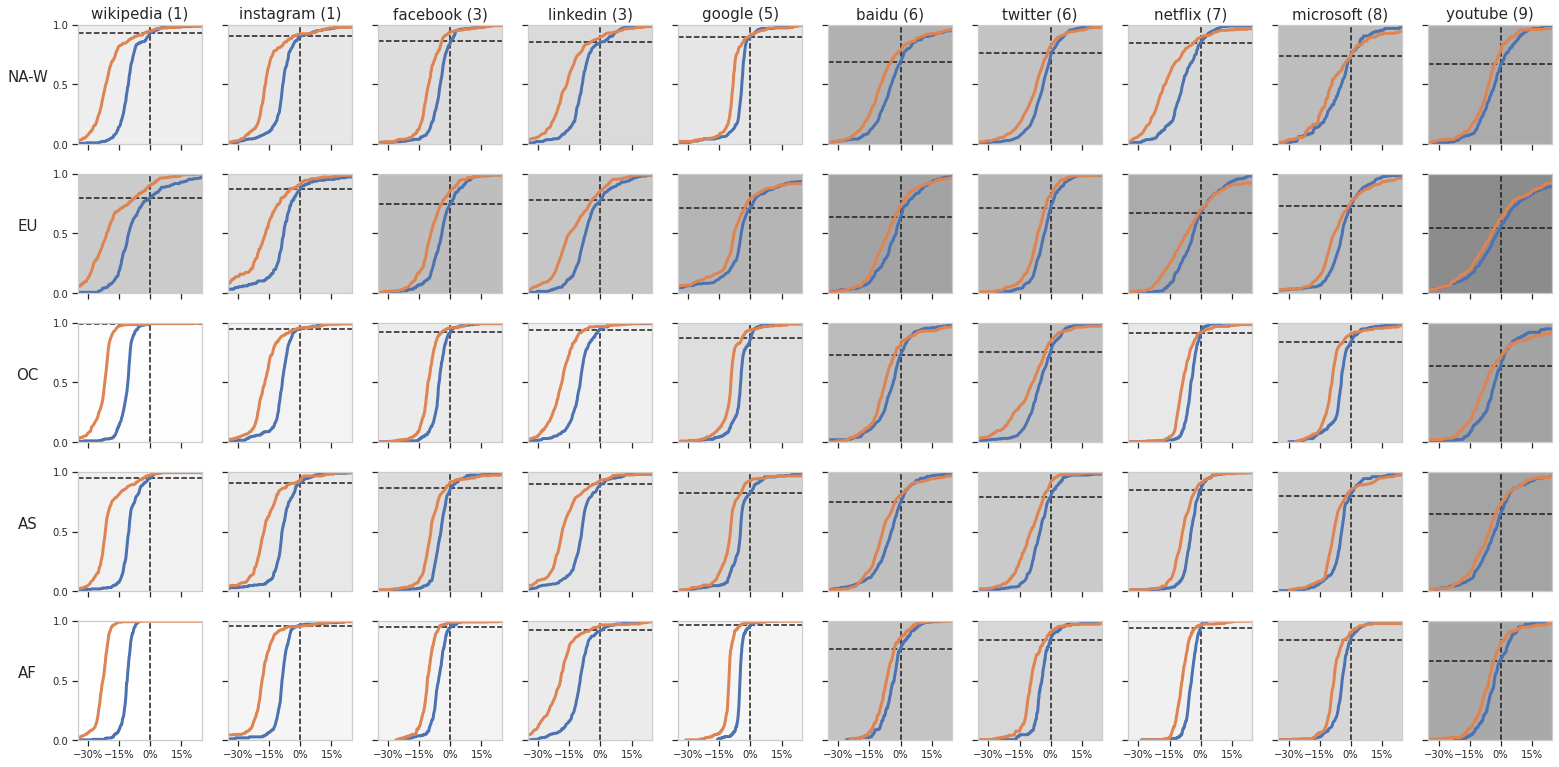

In [891]:
fig, axs = plt.subplots(5, 10, figsize=(22, 11), sharex=True, sharey=True)
tmp_order = vp_order.copy()
tmp_order.remove('South America East')

for i, domain in enumerate(domain_order):
    for j, vp in enumerate(tmp_order):
        print(f'\n{domain} - {vp}')
        ax = axs[j, i]
        data = diff_df[(diff_df['vantagePoint'] == vp) & (diff_df['domain'] == domain)].copy()
        create_comparison(data, ax, metric='PLT', baseline='DoH', compare_to_2='DoUDP')
        
tmp_order = []        
for index, row in df_new.iterrows():
    tmp_order.append(f"{index.split('.')[-2]} ({int(row['queries'])})")

for ax, col in zip(axs[0], tmp_order):
    ax.set_title(col, size='small')

for ax, row in zip(axs[:,0], ['NA-W', 'EU', 'OC', 'AS', 'AF']):
    ax.set_ylabel(row, rotation=0, size='small', labelpad=25)

fig.tight_layout()
plt.savefig("figures/doh-baseline-cluster.pdf", bbox_inches='tight')
plt.show()

In [733]:
def create_comparison2(data, ax, metric='PLT', baseline='DoUDP', compare_to='DoQ', compare_to_2=None):
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx
    
    key = f'{compare_to}-{metric}'
    x = data[[key]].copy()
    x = x[x[key] < np.inf]
    x = x[~np.isnan(x)]
    plot_x, plot_y = calculateCDF(x, bins=400)
    zero = find_nearest(plot_x, 10)
    sns.lineplot(x=plot_x, y=plot_y, ax=ax, linewidth=3)
    if plot_y[zero] < 0.5:
        c = 'w'
    else:
        c = 'k'
    ax.vlines([10], 0, 1, c, linestyles='dashed')
    ax.hlines([plot_y[zero]], -10, 45, c, linestyles='dashed')
    
    if compare_to_2:
        key = f'{compare_to_2}-{metric}'
        y = data[[key]].copy()
        y = y[y[key] < np.inf]
        y = y[~np.isnan(y)]
        plot_a, plot_n = calculateCDF(y, bins=400)
        sns.lineplot(x=plot_a, y=plot_n, ax=ax, linewidth=3)

    ax.set_facecolor(plt.cm.binary((1-plot_y[zero])))
    ax.tick_params(left=True, bottom=True, labelsize=10)
    ax.set_ylim(0.0, 1.0)
    ax.yaxis.set_ticks(np.arange(0.0, 1.01, 0.5))
    ax.xaxis.set_ticks(np.arange(-10, 45, 20))
    ax.set_xlim(-10, 45)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter())
    ax.grid(False)

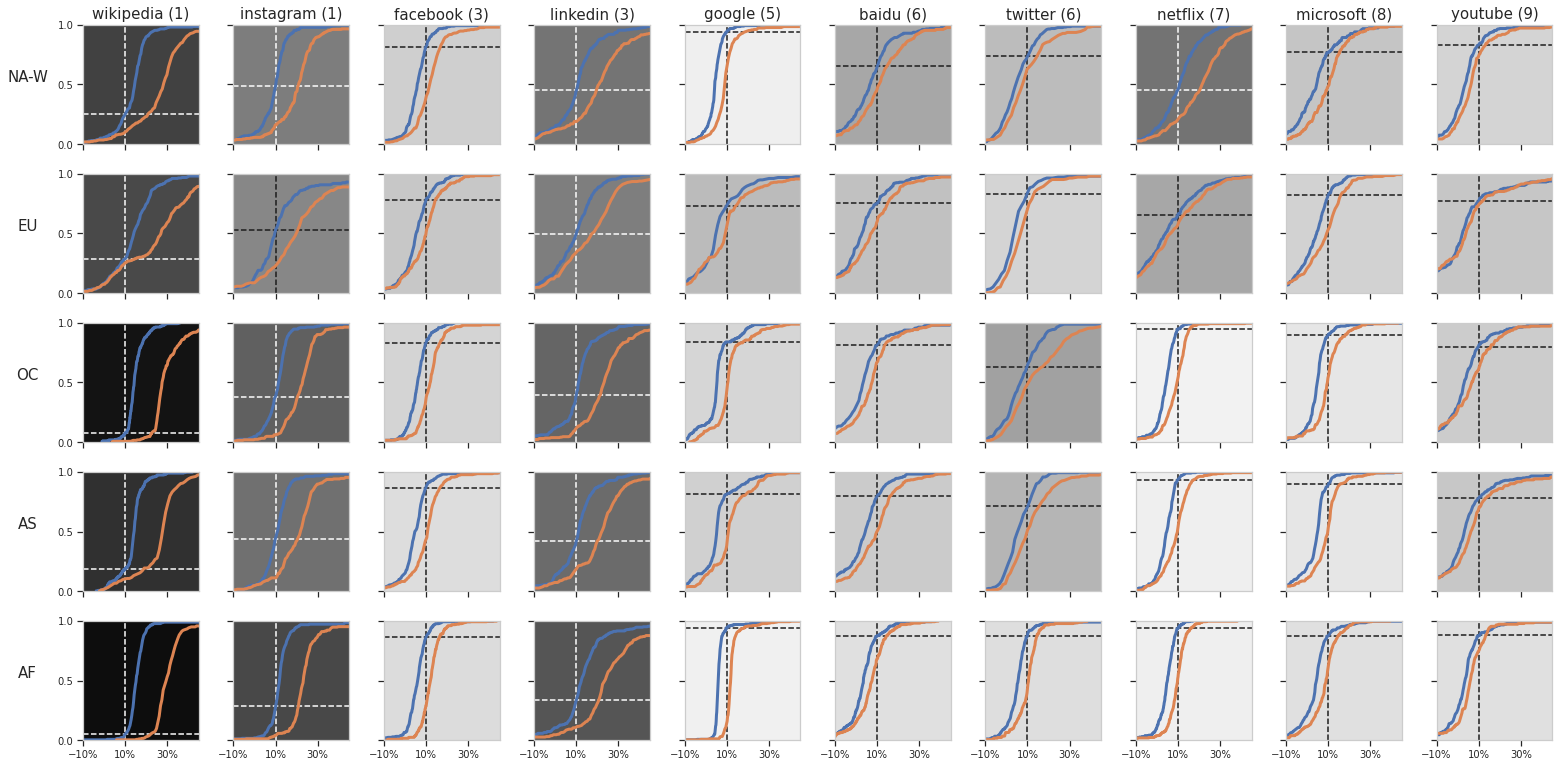

In [734]:
fig, axs = plt.subplots(5, 10, figsize=(22, 11), sharex=True, sharey=True)
tmp_order = vp_order.copy()
tmp_order.remove('South America East')

for i, domain in enumerate(domain_order):
    for j, vp in enumerate(tmp_order):
        ax = axs[j, i]
        data = diff_df2[(diff_df2['vantagePoint'] == vp) & (diff_df2['domain'] == domain)].copy()
        create_comparison2(data, ax, metric='PLT', baseline='DoUDP', compare_to='DoQ', compare_to_2='DoH')
        
tmp_order = []        
for index, row in df_new.iterrows():
    tmp_order.append(f"{index.split('.')[-2]} ({int(row['queries'])})")

for ax, col in zip(axs[0], tmp_order):
    ax.set_title(col, size='small')

for ax, row in zip(axs[:,0], ['NA-W', 'EU', 'OC', 'AS', 'AF']):
    ax.set_ylabel(row, rotation=0, size='small', labelpad=30)

fig.tight_layout()
plt.show()

In [892]:
diff_df2.nlargest(10, 'DoQ-PLT').groupby(['vantagePoint', 'server']).size()

vantagePoint            server        
Asia Pacific Northeast  140.238.10.79     1
Asia Pacific Southeast  192.3.127.219     1
                        46.3.242.170      1
Europe Central          164.92.136.119    1
                        23.94.120.177     1
                        45.78.51.5        1
                        46.3.242.170      1
                        94.140.14.49      1
                        94.140.14.59      1
South America East      46.3.242.170      1
dtype: int64

In [897]:
df[(df['server'] == '45.78.51.5') & (df['vantagePoint'] == 'Europe Central') & (df['domain'] == 'www.youtube.com') &((df['protocol'] == 'QUIC') | (df['protocol'] == 'UDP'))].sort_values('domain')

,domain,protocol,server,vantagePoint,requestStart,responseStart,firstContentfulPaint,loadEventStart,loadEventEnd,encodedBodySize,...,answer,elapsed,approx_rtt,rts,timeByTransferSize,timeByDecodedSize,difLookupFcp,difFcpEnd,difLookupEnd,serverRTT
id,,,,,,,,,,,,,,,,,,,,,
50589cc6-87d8-f513-52b1-886eb70fdc86,www.youtube.com,QUIC,45.78.51.5,Europe Central,1081.0,1380.0,3494.2,5541.4,5542.1,61216,...,"www.youtube.com.,362,IN,CNAME,youtube-ui.l.goo...",522.091353,257.580499,2.026906,0.090081,0.008338,2972.108647,2047.2,5019.308647,299.0
a7f5fccf-2c2e-db44-5394-4c580a8de979,www.youtube.com,UDP,45.78.51.5,Europe Central,814.4,1117.1,3259.1,7018.6,7019.1,60369,...,"www.youtube.com.,133,IN,CNAME,youtube-ui.l.goo...",259.308741,257.580499,1.006710,0.115687,0.010790,2998.057062,3759.5,6759.291259,302.7
78a95df8-8f8e-b451-e537-316880acf53a,www.youtube.com,QUIC,45.78.51.5,Europe Central,1069.8,1376.4,3499.8,7851.8,7852.3,64853,...,"www.youtube.com.,361,IN,CNAME,youtube-ui.l.goo...",520.126784,257.580499,2.019279,0.120513,0.011167,2979.673216,4352.0,7331.673216,306.6
2e03d2e6-932f-a729-51d9-f46e72a26943,www.youtube.com,UDP,45.78.51.5,Europe Central,803.7,1104.2,3214.3,7563.3,7563.9,60414,...,"www.youtube.com.,139,IN,CNAME,youtube-ui.l.goo...",256.369757,257.580499,0.995300,0.124573,0.011610,2952.907154,4349.0,7306.930243,300.5
5f95ecee-f969-7f9d-b33b-f983f177eabf,www.youtube.com,QUIC,45.78.51.5,Europe Central,1066.2,1373.5,3590.0,7884.5,7885.6,60938,...,"www.youtube.com.,361,IN,CNAME,youtube-ui.l.goo...",519.238738,257.580499,2.015831,0.128752,0.011883,3070.761262,4294.5,7365.261262,307.3
18e9949c-ff7b-7628-72eb-40fc18794048,www.youtube.com,UDP,45.78.51.5,Europe Central,837.2,1134.8,3503.1,7649.4,7650.0,60216,...,"www.youtube.com.,134,IN,CNAME,youtube-ui.l.goo...",257.866790,257.580499,1.001111,0.126403,0.011476,3243.666186,4146.3,7391.533210,297.6
29f4ed62-5c78-7936-d090-b29819f7bfd1,www.youtube.com,QUIC,45.78.51.5,Europe Central,1058.3,1362.1,3490.0,9849.0,9849.5,60412,...,"www.google.com.,324,IN,A,142.250.207.100|",256.289434,257.580499,0.994988,0.162225,0.015128,2975.852661,6359.0,9592.710566,303.8
b9399094-8e2c-3b60-340f-d038de4e4810,www.youtube.com,UDP,45.78.51.5,Europe Central,821.5,1122.5,3236.7,7513.3,7513.8,60882,...,"www.youtube.com.,126,IN,CNAME,youtube-ui.l.goo...",256.175560,257.580499,0.994546,0.122802,0.011486,2977.658456,4276.6,7257.124440,301.0


In [853]:
#diff_df2[(diff_df2['vantagePoint'] == 'Africa South') & (diff_df2['domain'] == 'www.instagram.com')]
print(len(diff_df.index))

14330


# Metrics

In [168]:
df_dns_perf_metrics = pd.read_sql_query("SELECT * FROM dns_metrics", connection)


df_dns_perf_metrics['metric'] = df_dns_perf_metrics['metric'].replace({'metrics:DoUDP UDP setup duration from': 'metrics:DoUDP UDP setup duration from '}, regex=True)


df_dns_perf_metrics['metric_type'] = "none"

df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("setup duration"), "handshake", df_dns_perf_metrics['metric_type'])

df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("exchange duration"), "exchange", df_dns_perf_metrics['metric_type'])

df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("query duration"), "query", df_dns_perf_metrics['metric_type'])

df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("handshake duration"), "handshake", df_dns_perf_metrics['metric_type'])

df_dns_perf_metrics['metric_type'] = np.where(df_dns_perf_metrics.metric.str.contains("DoH query"), "lazy-init-handshake-and-query", df_dns_perf_metrics['metric_type'])


df_dns_perf_metrics['duration'] = df_dns_perf_metrics.metric.str.split(' ').str[-1]

df_dns_perf_metrics['duration'] = df_dns_perf_metrics['duration'].str[:-2]


df_dns_perf_metrics['base'] = 1000

df_dns_perf_metrics['base'] = np.where(df_dns_perf_metrics.duration.str[-1] == 'm', 1, df_dns_perf_metrics['base'])

df_dns_perf_metrics['base'] = np.where(df_dns_perf_metrics.duration.str[-1] == 'µ', 1/1000, df_dns_perf_metrics['base'])


df_dns_perf_metrics['duration'] = np.where((df_dns_perf_metrics.duration.str[-1] != 'm') & (df_dns_perf_metrics.duration.str[-1] != 'µ'), df_dns_perf_metrics['duration']+'s', df_dns_perf_metrics['duration'])


df_dns_perf_metrics['duration'] = df_dns_perf_metrics['duration'].str[:-1]

df_dns_perf_metrics['duration'] = df_dns_perf_metrics['duration'].astype(float) * df_dns_perf_metrics['base']


df_dns_perf_metrics['metric'] = df_dns_perf_metrics['metric'].str[8:]


df_dns_perf_metrics['metric_start'] = df_dns_perf_metrics['metric'].str.extract(r'\sfrom\s(.*?)\sto\s')


df_dns_perf_metrics['metric_end'] = df_dns_perf_metrics['metric'].str.extract(r'\sto\s(.*?)\:\s')


df_dns_perf_metrics['protocol'] = df_dns_perf_metrics.metric.str.split(' ').str[0]


df_dns_perf_metrics['domain'] = df_dns_perf_metrics['metric'].str.extract(r'\sfor\s\[\;(.*?)\]\s')


df_dns_perf_metrics.metric_start = "2022 "+df_dns_perf_metrics.metric_start

df_dns_perf_metrics.metric_end = "2022 "+df_dns_perf_metrics.metric_end


df_dns_perf_metrics.metric_start = pd.to_datetime(df_dns_perf_metrics.metric_start, format="%Y %b %d %H:%M:%S.%f")


df_dns_perf_metrics.metric_end = pd.to_datetime(df_dns_perf_metrics.metric_end, format="%Y %b %d %H:%M:%S.%f")


df_dns_perf_metrics.domain = df_dns_perf_metrics.domain.str[:-7]

In [171]:
df_dns_perf_metrics.head(5)

,measurement_id,metric,metric_type,duration,base,metric_start,metric_end,protocol,domain
0,4f56c3df-7e7f-c7a7-62e6-f3bfe20b491d,DoT TLS handshake duration from Apr 18 00:01:0...,handshake,257.418588,1.0,2022-04-18 00:01:05.937,2022-04-18 00:01:06.194,DoT,NaN
1,4f56c3df-7e7f-c7a7-62e6-f3bfe20b491d,DoT query duration for [;www.google.com.\tIN\t...,query,228.704594,1.0,2022-04-18 00:01:06.195,2022-04-18 00:01:06.423,DoT,www.google.com
2,4f56c3df-7e7f-c7a7-62e6-f3bfe20b491d,DoT exchange duration for [;www.google.com.\tI...,exchange,715.961301,1.0,2022-04-18 00:01:05.707,2022-04-18 00:01:06.423,DoT,www.google.com
3,4f56c3df-7e7f-c7a7-62e6-f3bfe20b491d,DoT query duration for [;www.gstatic.com.\tIN\...,query,228.722514,1.0,2022-04-18 00:01:07.381,2022-04-18 00:01:07.609,DoT,www.gstatic.com
4,4f56c3df-7e7f-c7a7-62e6-f3bfe20b491d,DoT exchange duration for [;www.gstatic.com.\t...,exchange,231.853087,1.0,2022-04-18 00:01:07.378,2022-04-18 00:01:07.610,DoT,www.gstatic.com


In [184]:
handshake_df = df_dns_perf_metrics[(df_dns_perf_metrics['metric_type'] == 'handshake') & (df_dns_perf_metrics['protocol'] != 'DoUDP') & (df_dns_perf_metrics['protocol'] != 'DoTCP')].copy()

In [185]:
handshake_df = handshake_df[['measurement_id', 'metric_type']].groupby('measurement_id').count()

In [187]:
handshake_df = handshake_df[handshake_df['metric_type'] > 1]

In [209]:
handshake_df.head(30)

,metric_type
measurement_id,
00006444-75d0-8e98-ee35-2ba26c3e54c0,2
00012975-518b-ee54-d8cd-0e60c9adaab8,4
00025315-fdf5-acce-6aba-f8e6178d29c2,4
00041acc-c8e4-474f-6ba7-cbab24acd75c,2
00048c06-bbda-cf56-a63c-d492e5948e1f,2
00060281-7953-fcee-87d8-3bc9254d6d90,3
0006407c-a220-0876-de59-3324a9c1184f,5
00068226-65c0-5de8-aa9d-1cc5f9aa1342,2
000730f3-9f75-d754-1f2f-602ecef3a602,3


In [207]:
protocols_hs = {'TLS': 0, 'HTTPS': 0, 'QUIC': 0}
for index, row in handshake_df.iterrows():
    try:
        prot = df.loc[index, ['protocol']]['protocol']
        protocols_hs[prot] += 1
    except:
        pass
print(protocols_hs)

{'TLS': 39674, 'HTTPS': 0, 'QUIC': 3}


In [190]:
print('hello')

hello


In [217]:
handshake_df_2 = df_dns_perf_metrics[(df_dns_perf_metrics['metric_type'] == 'handshake') & (df_dns_perf_metrics['protocol'] != 'DoUDP') & (df_dns_perf_metrics['protocol'] != 'DoTCP')].copy()
handshake_df_2 = handshake_df_2[['measurement_id', 'metric_type']].groupby('measurement_id').count()
handshake_df_2 = handshake_df_2[handshake_df_2['metric_type'] == 1]

In [218]:
handshake_df_2.head()

,metric_type
measurement_id,
0000709a-d4ca-cde6-75ca-4fb2b5531234,1
0000b225-bbb8-4fa3-fa00-c3c08a5fbbbe,1
0000d379-8efa-ccd0-8194-c203f74bbbfe,1
00015b20-754f-f69a-fdf9-67a882f174f1,1
0001a792-8d17-f66e-bdec-cc802b1c4e2c,1


In [219]:
protocols_hs_2 = {'TLS': 0, 'HTTPS': 0, 'QUIC': 0}
for index, row in handshake_df_2.iterrows():
    try:
        prot = df.loc[index, ['protocol']]['protocol']
        protocols_hs_2[prot] += 1
    except:
        pass
print(protocols_hs_2)

{'TLS': 28700, 'HTTPS': 0, 'QUIC': 69291}
